##Utils

In [ ]:
!pip install mesa
!pip install networkx
!pip install bokeh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 3.5 MB/s 
     |████████████████████████████████| 66 kB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time, enum, math, random
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

import networkx as nx
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
import seaborn as sns
from scipy.stats import sem 

In [ ]:
#import community as community_louvain
import community.community_louvain as community_louvain
from sklearn.cluster import SpectralClustering
from scipy.sparse import csr_matrix
from itertools import count
from networkx.utils import not_implemented_for, py_random_state, BinaryHeap
from networkx.algorithms.community.community_utils import is_partition
import heapq

In [ ]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()

##Agent Model

In [ ]:
#SEIR
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    EXPOSED = 1
    INFECTED = 2
    REMOVED = 3

In [ ]:
def exp_rand(lam):
  if lam <= 0:
    return -1
  U = random.uniform(0.0, 1.0)
  return (-1.0 / lam) * math.log(U)

In [ ]:
class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        #self.age = int(self.random.normalvariate(20,40))
        self.unique_id = unique_id
        self.state = State.SUSCEPTIBLE 
        self.infection_time = 0
        self.infection_prob = exp_rand(model.infect_lam)
        self.node_degree = model.G.degree(unique_id-1)
        self.infection_counts = 0

    def move(self):
        """Move the agent"""

        possible_steps = [
            node
            for node in self.model.grid.get_neighbors(self.pos, include_center=False)
            if self.model.grid.is_cell_empty(node)
        ]
        if len(possible_steps) > 0:
            new_position = self.random.choice(possible_steps)                 
            self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""
        if self.state == State.EXPOSED:                 
            t = self.model.schedule.time-self.exposed_time
            if t >= self.model.incubation_time:          
                self.state = State.INFECTED
                self.infection_time = self.model.schedule.time

        
        if self.state == State.INFECTED:     
            #drate = self.model.death_rate
            #alive = np.random.choice([0,1], p=[drate,1-drate])
            #if alive == 0:
            #    self.model.schedule.remove(self)            
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:          
                self.state = State.REMOVED
            #print (self.model.schedule.time,self.recovery_time,t)

    def contact(self):
        """Find close contacts and infect"""
        self.infection_counts = 0
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state is State.SUSCEPTIBLE
        ]
        if self.state == State.INFECTED:
          for a in susceptible_neighbors:
              #if self.infection_prob < model.ptrans:
              if self.random.random() < self.infection_prob:
                  a.state = State.EXPOSED
                  a.exposed_time = model.schedule.time
                  a.recovery_time = model.get_recovery_time()
                  self.infection_counts += 1
                                  
    def step(self):
        self.status()
        self.move()
        self.contact()

    def toJSON(self):        
        d = self.unique_id
        return json.dumps(d, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)



## Infection Model


n = 500 #Number of nodes

m = 5 #Number of edges to attach from a new node to existing nodes

G = nx.barabasi_albert_graph(n, m)

In [ ]:
class NetworkInfectionModel(Model):
    """A model for infection spread."""
    
    def __init__(self, N=10, initial_outbreak_size = 20, data_G = nx.erdos_renyi_graph(n=10, p=0.012),#ptrans=0.5, 
                 avg_node_degree=3, #progression_period=3, progression_sd=2, #death_rate=0.0193, 
                 recovery_days=7, recovery_sd=4, incubation_time = 7, infect_lam = 6):
        
        #self.num_agents = N
        self.num_nodes = N  
        
        
        self.initial_outbreak_size = initial_outbreak_size
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        #self.ptrans = ptrans
        #self.death_rate = death_rate
        self.incubation_time = incubation_time
        self.infect_lam = infect_lam
        
        #define the network
        #self.G = nx.erdos_renyi_graph(n=self.num_nodes, p=prob)
        self.G = data_G
        self.grid = NetworkGrid(self.G)
        
        self.schedule = RandomActivation(self)
        self.running = True
        #self.dead_agents = []
        
        init_infect = random.sample(range(1,self.num_nodes), self.initial_outbreak_size)
        init_infect.sort()
        iter_key = 0

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            a = MyAgent(i+1, self)
            self.schedule.add(a)
            #add agent
            self.grid.place_agent(a, node)

            #make some agents infected at start
            #infected = np.random.choice([0,1], p=[0.99,0.01])
            if iter_key < self.initial_outbreak_size:
              if i == init_infect[iter_key]:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()
                iter_key += 1

        self.datacollector = DataCollector(
            agent_reporters={"State": "state"})
        self.datacollector_infection_counts = DataCollector(
            agent_reporters={"Secondary_transmission": "infection_counts", "p":"infection_prob", "node_degree":"node_degree"})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))

    def remove(id, self):
        #self.schedule.agents[id].state = State.REMOVED
        for agent in self.schedule.agents:
            if agent.unique_id == id:
              agent.state = State.REMOVED

    def step(self):
        self.datacollector.collect(self)
        self.datacollector_infection_counts.collect(self)
        self.schedule.step()
        
        

In [ ]:
model = NetworkInfectionModel(300)
model.step()
model

In [ ]:
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Exposed','Infected','Removed']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=4,alpha=0.8)
    return f

def get_secondary_transmission(model):
    #pivot the dataframe to get the number of secondary transmission that each agent caused
    ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
    icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
    return icc_cc

##Graph Partition

In [ ]:
def random_groups(G, size):
    """Generates random groups for testing."""
    nodes = list(G.nodes())
    np.random.shuffle(nodes)

    groups = [[]]
    for i in range(len(nodes)):
        if len(groups[-1]) == size:
            groups.append([])
            
        groups[-1].append(nodes[i])
    
    return groups

  
def cluster_groups(clusters, size):
    """Generates groups for testing from clusters"""
    clusters.sort(key=len, reverse=True)
    
    clustered_nodes = []
    for c in range(len(clusters)):
        clustered_nodes = clustered_nodes + clusters[c]
    
    groups = [[]]
    for i in range(len(clustered_nodes)):
        if len(groups[-1]) == size:
            groups.append([])
            
        groups[-1].append(clustered_nodes[i])
        
    return groups

def modularity_min(G, weight='weight'):
    '''Modularity minimization clustering.Returns list of clusters.'''
    if weight is None:
        vertex_cluster = community_louvain.best_partition(G)
    else:
        vertex_cluster = community_louvain.best_partition(G, weight=weight)
            
    clusters = []
        
    for c in range(np.max(list(vertex_cluster.values()))+1):
        clusters.append([])
    
    for v in vertex_cluster:
        c = vertex_cluster[v]
        clusters[c].append(v)
    
    return clusters

def topol_greedy_group(G, group_size, weight='weight'):
    '''
        Greedily groups two sets of nodes by maximizing 
        the total weight inside groups at each step.
    '''
    group_assign = {}
    groups = []
    
    #Groups initialized as singletons
    for v in G.nodes():
        group_assign[v] = len(groups)
        groups.append([v])

    #Each edge is a candidate merge
    #weights stores cross group weights for pairs
    weights = {}
    heap = []
    for e in G.edges:
        if weight is None:
            w = 1.
        else:
            w = G.edges[e]['weight']
        
        idx_i = min(group_assign[e[0]], group_assign[e[1]])
        idx_j = max(group_assign[e[0]], group_assign[e[1]])
        
        if idx_i not in weights:
            weights[idx_i] = {}
            
        if idx_j not in weights:
            weights[idx_j] = {}
        
        weights[idx_i][idx_j] = w
        weights[idx_j][idx_i] = w
        
        heap.append((-w, (idx_i,idx_j)))
    
    heapq.heapify(heap)
    
    while len(heap) > 0:
        item = heapq.heappop(heap)
        idx_i = item[1][0]
        idx_j = item[1][1]

        if len(groups[idx_i]) > 0 and len(groups[idx_j]) > 0:
            if len(groups[idx_i])+len(groups[idx_j]) <= group_size:
                
    #Picks next merge and creates new group
                idx_new = len(groups)
                weights[idx_new] = {}
                groups.append(groups[idx_i]+groups[idx_j])
                
                groups[idx_i] = []
                groups[idx_j] = []
                
    #Updates weights for new group
                for c in weights[idx_i]:
                    if c != idx_j and len(groups[c]) > 0:
                        w = weights[idx_i][c]
                        
                        if c in weights[idx_j]:
                            w = w + weights[idx_j][c]
                        
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
                for c in weights[idx_j]:
                    if c != idx_i and len(groups[c]) > 0 and c not in weights[idx_new]:
                        w = weights[idx_j][c]
                        
                        if c in weights[idx_i]:
                            w = w + weights[idx_i][c]
                            
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
    non_empty_groups = []   
    for g in groups:
        if len(g) > 0:
            non_empty_groups.append(g)
            
    return cluster_groups(non_empty_groups, group_size)


def topol_greedy_group_degree(G, group_size, weight='weight'):
    '''
        Greedily groups two sets of nodes by maximizing 
        the total node degree inside groups at each step.
    '''
    group_assign = {}
    groups = []
    
    #Groups initialized as singletons
    for v in G.nodes():
        group_assign[v] = len(groups)
        groups.append([v])

    #Each edge is a candidate merge
    #weights stores cross group weights for pairs
    weights = {}
    heap = []
    for e in G.edges:
        if weight is None:
            w = 1.
        else:
            w = G.edges[e]['weight']
        
        idx_i = min(group_assign[e[0]], group_assign[e[1]])
        idx_j = max(group_assign[e[0]], group_assign[e[1]])
        
        if idx_i not in weights:
            weights[idx_i] = {}
            
        if idx_j not in weights:
            weights[idx_j] = {}
        
        weights[idx_i][idx_j] = w
        weights[idx_j][idx_i] = w
        
        heap.append((-w, (idx_i,idx_j)))
    
    heapq.heapify(heap)
    
    while len(heap) > 0:
        item = heapq.heappop(heap)
        idx_i = item[1][0]
        idx_j = item[1][1]

        if len(groups[idx_i]) > 0 and len(groups[idx_j]) > 0:
            if len(groups[idx_i])+len(groups[idx_j]) <= group_size:
                
		#Picks next merge and creates new group
                idx_new = len(groups)
                weights[idx_new] = {}
                groups.append(groups[idx_i]+groups[idx_j])
                
                groups[idx_i] = []
                groups[idx_j] = []
                
		#Updates weights for new group
                for c in weights[idx_i]:
                    if c != idx_j and len(groups[c]) > 0:
                        w = weights[idx_i][c]
                        
                        if c in weights[idx_j]:
                            w = w + weights[idx_j][c]
                        
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
                for c in weights[idx_j]:
                    if c != idx_i and len(groups[c]) > 0 and c not in weights[idx_new]:
                        w = weights[idx_j][c]
                        
                        if c in weights[idx_i]:
                            w = w + weights[idx_i][c]
                            
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
    non_empty_groups = []   
    for g in groups:
        if len(g) > 0:
            non_empty_groups.append(g)
            
    return cluster_groups(non_empty_groups, group_size)

In [ ]:
def max_intra_commu_greedy(G, group_size, weight='weight'):
    '''
        Greedily groups two sets of nodes by maximizing 
        the intra-community edges inside groups at each step.
    '''
    group_assign = {}
    groups = []
    
    #Groups initialized as singletons
    for v in G.nodes():
        group_assign[v] = len(groups)
        groups.append([v])

    #Each edge is a candidate merge
    #weights stores cross group weights for pairs
    weights = {}
    heap = []
    for e in G.edges:
        if weight is None:
            w = 1.
        else:
            w = G.edges[e]['weight']
        
        idx_i = min(group_assign[e[0]], group_assign[e[1]])
        idx_j = max(group_assign[e[0]], group_assign[e[1]])
        
        if idx_i not in weights:
            weights[idx_i] = {}
            
        if idx_j not in weights:
            weights[idx_j] = {}
        
        weights[idx_i][idx_j] = w
        weights[idx_j][idx_i] = w
        
        heap.append((-w, (idx_i,idx_j)))
    
    heapq.heapify(heap)
    
    while len(heap) > 0:
        item = heapq.heappop(heap)
        idx_i = item[1][0]
        idx_j = item[1][1]

        if len(groups[idx_i]) > 0 and len(groups[idx_j]) > 0:
            if len(groups[idx_i])+len(groups[idx_j]) <= group_size:
                
		#Picks next merge and creates new group
                idx_new = len(groups)
                weights[idx_new] = {}
                groups.append(groups[idx_i]+groups[idx_j])
                
                groups[idx_i] = []
                groups[idx_j] = []
                
		#Updates weights for new group
                for c in weights[idx_i]:
                    if c != idx_j and len(groups[c]) > 0:
                        w = G.subgraph([c, idx_i]).number_of_edges()
                        
                        if c in weights[idx_j]:
                            w = G.subgraph([c, idx_i, idx_j]).number_of_edges()
                        
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        heapq.heappush(heap, (-w, (c, idx_new)))
                        
                for c in weights[idx_j]:
                    if c != idx_i and len(groups[c]) > 0 and c not in weights[idx_new]:
                        w = G.subgraph([c, idx_j]).number_of_edges()
                        
                        if c in weights[idx_i]:
                            w = G.subgraph([c, idx_i, idx_j]).number_of_edges()
                            
                        weights[idx_new][c] = w
                        weights[c][idx_new] = w
                        heapq.heappush(heap, (-w, (c, idx_new)))

    non_empty_groups = []   
    for g in groups:
        if len(g) > 0:
            non_empty_groups.append(g)
            
    return cluster_groups(non_empty_groups, group_size)

In [ ]:
def evaluate_two_level_group_testing(infec_matrix, groups, capacity):
    '''
    '''
    n_tests =  capacity * np.ones(infec_matrix.shape[1])
    total = 0
    #TODO:sorted groups!!!
    
    for g in range(capacity):
        sz = len(groups[g])
        total = total+sz
        
        group = []
        for v in groups[g]:
            v = int(v)
            if v < infec_matrix.shape[0]:
                group.append(v)
        
        ind_test = infec_matrix[group].sum(axis=0)
        ind_test[ind_test > 0] = 1
        n_tests = n_tests + sz * ind_test
        
    return n_tests / total

# BA

In [ ]:
G = nx.barabasi_albert_graph(n=2000, m=3)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())

# of nodes:  2000
Average degree:  5.991


In [ ]:
def network_gen():
  G = nx.barabasi_albert_graph(n=2000, m=3)
  return G

##Testing Strategy _0

In [ ]:
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = network_gen())
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


12.229726552963257
      Susceptible  Exposed  Infected  Removed
Step                                         
0            1980        0        20        0
1            1974        6        18        2
2            1971        9        18        2
3            1969       11        18        2
4            1958       22        17        3
5            1951       29        15        5
6            1947       33        11        9
7            1941       39        11        9
8            1910       64        13       13
9            1834      137        14       15
10           1797      172        15       16
11           1751      207        23       19
12           1700      251        29       20
13           1653      294        30       23
14           1617      324        32       27
15           1560      350        61       29
16           1474      360       125       41
17           1389      408       152       51
18           1276      475       184       65
19           11

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  493
number_of_uninfected: 156


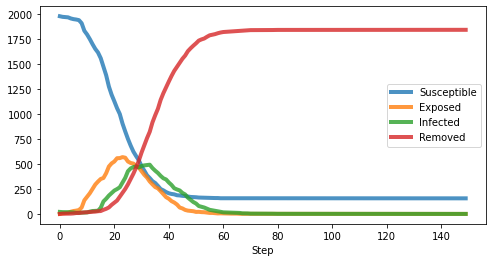

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
9                           117          139  0.392000
7                            71           79  0.342341
34                           41           55  0.290460
13                           35           58  0.238382
19                           24           35  0.651066
11                           21           44  0.204692
12                           20           53  0.100325
75                           19           31  0.169941
15                           18           48  0.109061
39                           16           41  0.108303
148                          15           32  0.411593
16                           15           25  0.270664
25                           15           38  0.111857
20                           14           37  0.111799
230                          14           23  0.345899
95                           13           25  0.342906
203                          12           16  0.370058
45                           11           23  0.248851
24                           11           38  0.106725
210                          10           15  0.283638

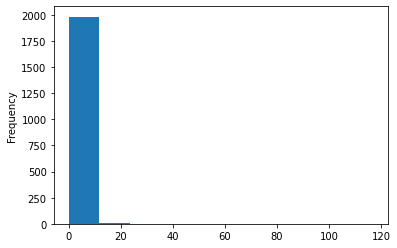

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

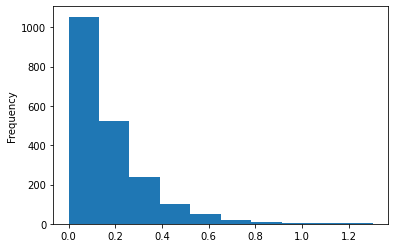

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      49.673143              578        41400                 27   
1      51.206845              530        41400                 32   
2      49.185803              661        41400                 44   
3      49.134371              574        41400                 26   
4      48.371258              849        41400                 67   
..           ...              ...          ...                ...   
95     56.246446              478        41400                 27   
96     51.175579              421        41400                 20   
97     50.242641              687        41400                 53   
98     50.313783              632        41400                 42   
99     52.947051              596        41400                 28   

    max_2_trans  num_of_S  
0            51      1294  
1            29      1356  
2            69      1197  
3            34      1305  
4            69       962  
..          ...       ...  
95           61      1417  
96           27      1485  
97          107      1153  
98           48      1224  
99           51      1264  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  51.08388944864273 0.13835297026263882
Average_found_positives:  606.87 10.947483959819492
Average_total_tests:  41400.0 0.0
Average_max_outbreak_size:  36.77 1.2281097407616044
Average_max_2_trans: 53.83 2.1871551098967523
Average_number_of_uninfected: 1258.6 13.351298503036011


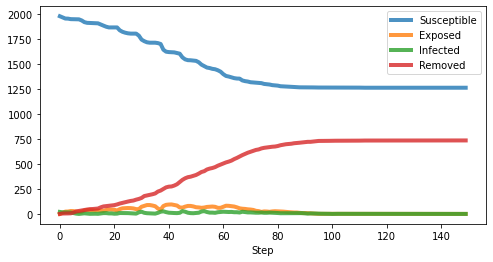

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


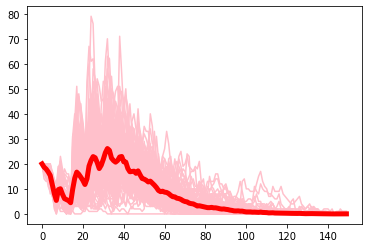

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

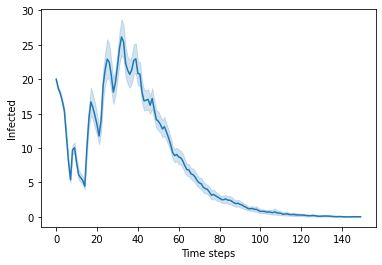

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
8                            51           88  0.477792
7                            29           99  0.199931
11                           25           33  0.409063
9                            24           35  0.219847
34                           18           34  0.242179
228                          14           23  0.622407
162                          11           23  0.073354
83                           10           20  0.469002
76                           10           19  0.592455
38                           10           26  0.191987
18                           10           34  0.189343
144                          10           14  0.452616
152                          10           15  0.378940
6                             9           65  0.198136
52                            9           37  0.098859
10                            9           67  0.066198
151                           8           13  0.525523
48                            8           30  0.307094
109                           8           18  0.229187
141                           8           13  0.664338

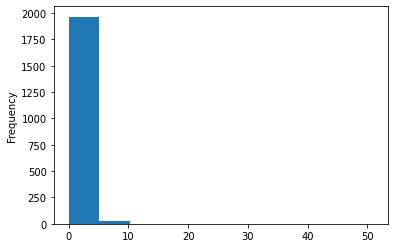

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

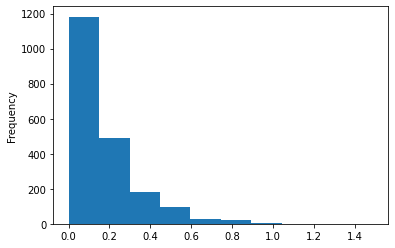

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      53.064651              701         5892                 42   
1      54.521882              525         5785                 32   
2      53.006651              603         5862                 20   
3      51.531552              621         5992                 38   
4      52.384907              711         6133                 52   
..           ...              ...          ...                ...   
95     52.518233              836         6469                 42   
96     53.405442              776         6458                 28   
97     50.900623              552         5826                 21   
98     54.148342              468         5571                 20   
99     53.406767              698         6248                 36   

    max_2_trans  num_of_S  
0            57      1230  
1            74      1409  
2            44      1349  
3            47      1326  
4            37      1238  
..          ...       ...  
95           50      1104  
96           57      1169  
97           39      1412  
98           25      1485  
99           40      1257  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  52.28295037984848 0.14138382494999124
Average_found_positives:  688.73 13.556018120109135
Average_total_tests:  6177.7 34.95838940653574
Average_max_outbreak_size:  35.91 1.2475507317471415
Average_max_2_trans: 51.15 1.850927968191724
Average_number_of_uninfected: 1260.08 14.100925394090169


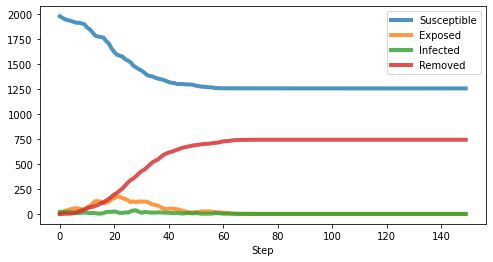

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


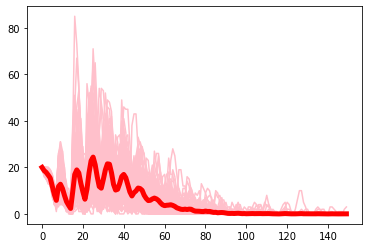

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


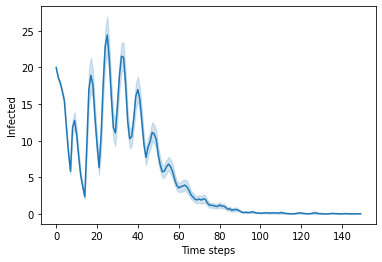

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1                            40          176  0.112846
25                           37           51  0.499758
15                           30           42  0.655260
17                           26           37  0.264572
14                           15           41  0.183812
43                           15           31  0.190673
5                            14           87  0.070217
127                          14           24  0.489822
38                           13           33  0.264082
9                            13           83  0.057126
36                           12           33  0.107514
27                           12           19  0.946589
19                           11           67  0.108337
55                           10           24  0.337006
112                          10           19  0.891507
7                             9          114  0.039180
13                            8           55  0.056725
80                            8           23  0.177285
18                            8           30  0.135084
95                            8           15  0.338495

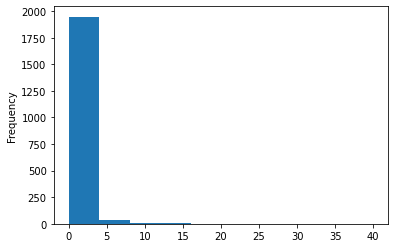

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

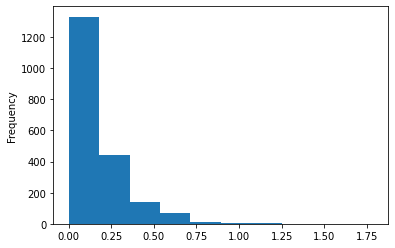

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      51.628881              905         6706                 58   
1      51.534222              851         6616                 58   
2      55.586345              766         6716                 35   
3      51.942191              815         6436                 54   
4      51.522482             1000         7199                 42   
..           ...              ...          ...                ...   
95     53.160396              646         6141                 42   
96     51.015817              719         6365                 34   
97     51.529380              886         6860                 50   
98     54.948105              811         6684                 44   
99     51.817598              697         6120                 58   

    max_2_trans  num_of_S  
0            37      1038  
1            44      1079  
2            32      1176  
3            45      1110  
4            48       915  
..          ...       ...  
95           83      1293  
96           58      1230  
97           46      1039  
98           44      1124  
99           47      1241  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  52.55539904117584 0.12999073343488682
Average_found_positives:  773.76 10.906935241562422
Average_total_tests:  6499.71 27.337025970081108
Average_max_outbreak_size:  40.95 1.2748836350146953
Average_max_2_trans: 51.02 2.0609882889703006
Average_number_of_uninfected: 1165.89 11.605335719905614


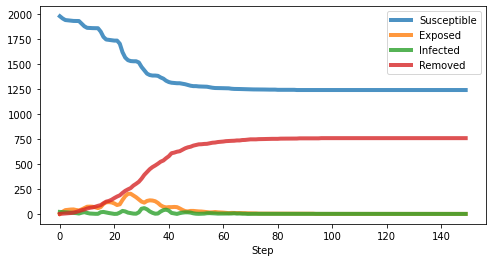

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


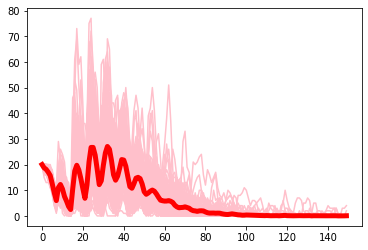

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


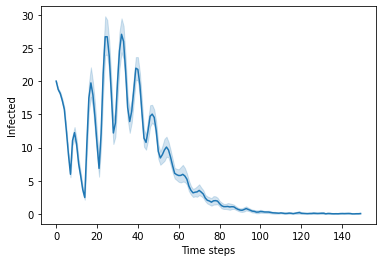

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
20                           47           57  0.529561
8                            42           85  0.227361
1                            25           90  0.275002
23                           24           58  0.205861
36                           20           36  0.367335
54                           19           43  0.337459
9                            17           49  0.164887
38                           15           43  0.248465
19                           12           30  0.228030
11                           12           78  0.061118
94                           11           18  0.537309
88                           11           18  0.598742
215                          11           13  0.609439
45                            8           13  0.449287
32                            8           26  0.380433
104                           8           13  0.159988
144                           8           11  0.921362
265                           7           14  0.469078
108                           6           14  0.206647
199                           6            9  0.370903

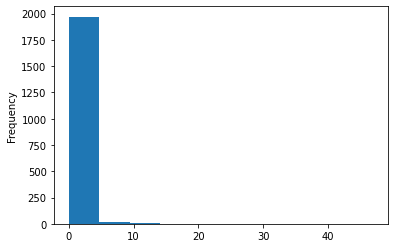

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

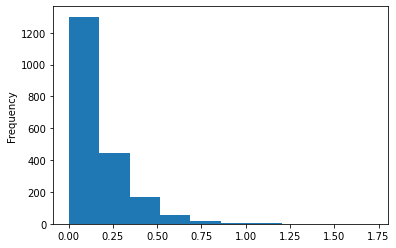

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      62.028060              644         6201                 31   
1      67.576687              744         6761                 53   
2      64.348999              822         7006                 41   
3      65.509105              758         6733                 35   
4      67.378578              865         6836                 76   
..           ...              ...          ...                ...   
95     67.394208              756         6968                 36   
96     66.090530              861         6823                 70   
97     63.368651              583         6053                 38   
98     64.751479              669         6711                 33   
99     63.372574              712         6530                 30   

    max_2_trans  num_of_S  
0            41      1306  
1            57      1209  
2            46      1115  
3            32      1189  
4            80      1070  
..          ...       ...  
95           43      1187  
96           74      1077  
97           43      1358  
98           48      1263  
99           38      1234  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  65.17649905920028 0.19812927078186032
Average_found_positives:  745.98 10.543838068375349
Average_total_tests:  6756.13 38.08468674738529
Average_max_outbreak_size:  43.69 1.4910300825505522
Average_max_2_trans: 49.82 1.9397167345004298
Average_number_of_uninfected: 1196.65 11.106039625429768


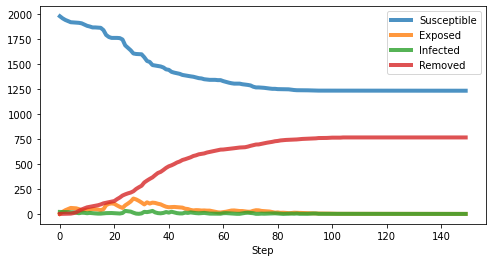

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


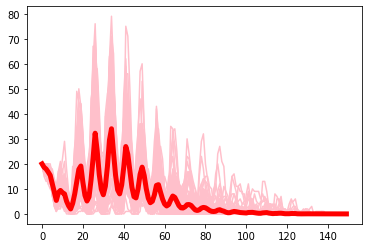

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


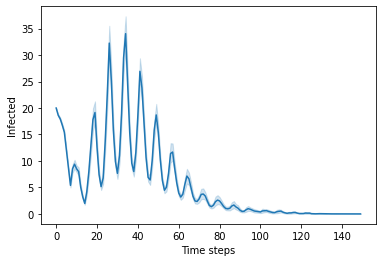

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
3                            38           59  0.344007
21                           31           51  0.257579
42                           30           34  0.932736
100                          20           34  0.673079
9                            20           57  0.062116
5                            19          124  0.041207
14                           18           25  0.480277
55                           17           27  0.404546
16                           17           49  0.158194
8                            16           55  0.104053
33                           15           33  0.406528
40                           14           26  0.277779
1                            13          148  0.023690
64                           10           19  0.346103
24                            9           36  0.127466
212                           9           13  0.748825
327                           9           14  0.318788
70                            8           14  0.471823
20                            8           30  0.058120
73                            7           13  0.905232

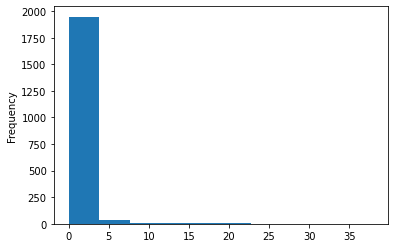

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

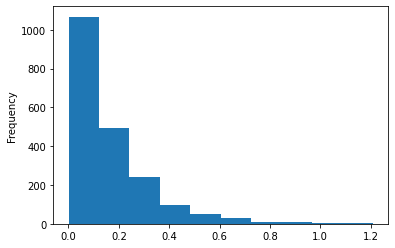

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(1026, 94), (255, 96), (1755, 98), (1652, 98), (1116, 99)]

In [ ]:
group_df

Group  Degree  Intra_C  \
72   [582, 600, 1355, 1756, 1553, 1926, 1662, 555, ...      48        8   
116  [559, 666, 1616, 662, 867, 1746, 1036, 387, 50...      58        7   
39   [1020, 1924, 1625, 131, 401, 1181, 381, 959, 1...      48        9   
13   [571, 631, 953, 1056, 781, 1335, 1617, 1147, 4...      47        9   
73   [723, 718, 337, 635, 877, 909, 1220, 1720, 652...      55        7   
..                                                 ...     ...      ...   
99   [1066, 1450, 1782, 762, 202, 506, 604, 1588, 1...      52        8   
66   [185, 526, 826, 1217, 1185, 1249, 390, 1671, 4...      51        8   
50   [256, 841, 625, 824, 1954, 379, 1169, 1241, 22...      60        7   
38   [987, 1626, 1054, 1328, 1110, 1765, 1409, 815,...      52        9   
12   [453, 1230, 1657, 1579, 1600, 803, 579, 774, 1...      52        9   

        order  record  flag  
72   0.000031      20     1  
116  0.000031      20     1  
39   0.000031      20     1  
13   0.000031      20     1  
73   0.000031      20     1  
..        ...     ...   ...  
99   0.000031      20     0  
66   0.000031      20     0  
50   0.000031      20     0  
38   0.000031      20     0  
12   0.000031      20     0  

[200 rows x 6 columns]

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
3                            38           59  0.344007
21                           31           51  0.257579
42                           30           34  0.932736
100                          20           34  0.673079
9                            20           57  0.062116
5                            19          124  0.041207
14                           18           25  0.480277
55                           17           27  0.404546
16                           17           49  0.158194
8                            16           55  0.104053
33                           15           33  0.406528
40                           14           26  0.277779
1                            13          148  0.023690
64                           10           19  0.346103
24                            9           36  0.127466
212                           9           13  0.748825
327                           9           14  0.318788
70                            8           14  0.471823
20                            8           30  0.058120
73                            7           13  0.905232

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      61.445140              404         5190                 20   
1      60.599910              517         5415                 20   
2      63.401496              631         5797                 36   
3      60.376242              348         5041                 20   
4      58.108151              348         5050                 20   
..           ...              ...          ...                ...   
95     62.497628              496         5595                 28   
96     62.797216              523         5732                 20   
97     62.456207              528         5521                 35   
98     59.979129              375         5002                 20   
99     63.735688              496         5586                 25   

    max_2_trans  num_of_S  
0            32      1550  
1            30      1428  
2            66      1285  
3            17      1601  
4            23      1611  
..          ...       ...  
95           21      1447  
96           18      1433  
97           21      1398  
98           41      1581  
99           16      1448  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  60.29265597343445 0.2989209563227669
Average_found_positives:  417.61 15.610601778239936
Average_total_tests:  5257.45 50.09543291548541
Average_max_outbreak_size:  26.2 0.9577962922113124
Average_max_2_trans: 30.38 1.7691965876229148
Average_number_of_uninfected: 1526.25 18.05868310130989


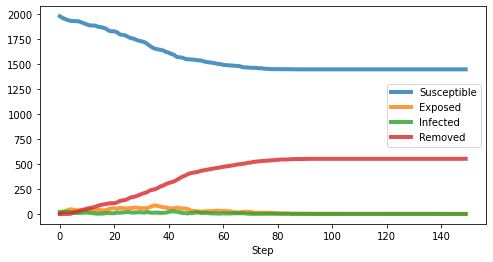

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


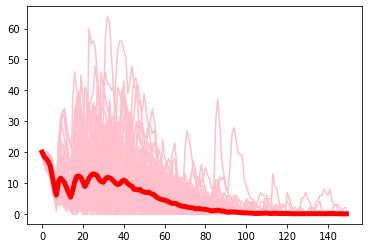

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


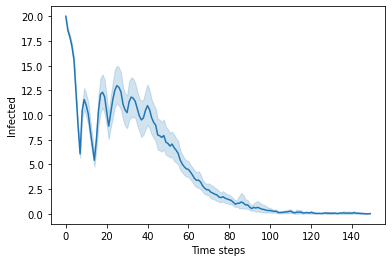

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
77                           16           33  0.163041
12                           15           44  0.189535
31                           13           16  1.012430
60                           12           34  0.157830
67                           12           16  0.691321
629                          12           14  0.444369
30                           11           24  0.259495
48                           11           43  0.097877
17                           10           29  0.118752
468                          10           14  0.275763
102                          10           15  0.831830
96                           10           14  0.319935
76                           10           16  0.544493
66                           10           38  0.311412
156                           9           11  0.225370
306                           8           12  0.667421
472                           7            8  0.285322
818                           7           11  0.185647
217                           6           11  0.223322
466                           6            7  0.653484

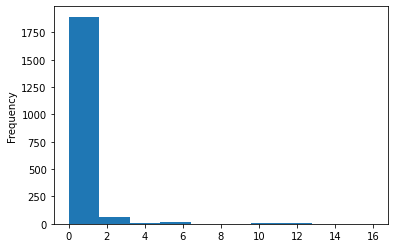

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

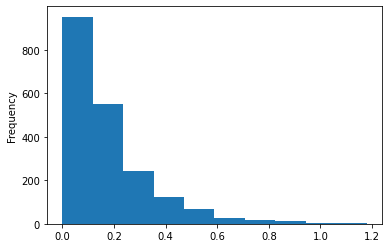

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(576, 84), (1224, 84), (502, 86), (1425, 89), (388, 91)]

In [ ]:
group_df

Group  Degree  Intra_C  \
129  [1503, 1407, 208, 352, 1494, 367, 700, 947, 64...      71        6   
145  [1272, 1806, 1009, 228, 537, 1789, 605, 1099, ...      47        6   
92   [1630, 1030, 1144, 1383, 1437, 272, 42, 55, 16...      69        9   
109  [824, 1236, 1938, 1508, 566, 1238, 1790, 760, ...      46        8   
65   [397, 654, 975, 249, 274, 1970, 1433, 454, 536...      61        7   
..                                                 ...     ...      ...   
112  [1849, 1619, 546, 683, 1942, 1869, 949, 1058, ...      43        7   
128  [1474, 273, 1094, 1609, 1010, 158, 254, 1492, ...      57        8   
77   [1327, 1573, 664, 894, 1676, 965, 1137, 682, 1...      41        7   
174  [1835, 670, 1697, 1612, 77, 956, 1692, 365, 63...      40        7   
97   [1202, 290, 1350, 1166, 484, 505, 1952, 967, 1...      49        6   

        order  record  flag  
129  0.000024      22     1  
145  0.000024      19     1  
92   0.000024      19     1  
109  0.000024      20     1  
65   0.000024      20     1  
..        ...     ...   ...  
112  0.000024      17     0  
128  0.000024      20     0  
77   0.000024      17     0  
174  0.000024      17     0  
97   0.000024      19     0  

[200 rows x 6 columns]

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
77                           16           33  0.163041
12                           15           44  0.189535
31                           13           16  1.012430
60                           12           34  0.157830
67                           12           16  0.691321
629                          12           14  0.444369
30                           11           24  0.259495
48                           11           43  0.097877
17                           10           29  0.118752
468                          10           14  0.275763
102                          10           15  0.831830
96                           10           14  0.319935
76                           10           16  0.544493
66                           10           38  0.311412
156                           9           11  0.225370
306                           8           12  0.667421
472                           7            8  0.285322
818                           7           11  0.185647
217                           6           11  0.223322
466                           6            7  0.653484

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

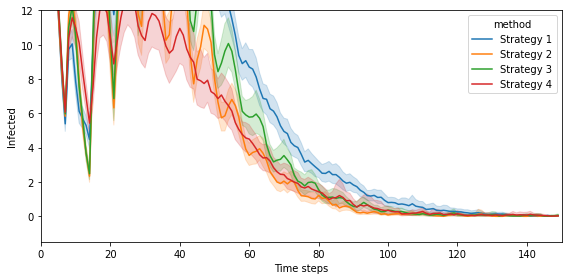

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 150)
plt.ylim(top = 12)
plt.tight_layout()

# Chung-Lu

In [ ]:
edge_list = np.round(np.random.power(0.5,2000)*6 + 4)
G_temp = nx.expected_degree_graph([int(i) for i in edge_list],selfloops = False)
[G_temp.add_edge(i, random.randint(0,1999)) for i in list(nx.isolates(G_temp))]
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
print(list(nx.isolates(G)))

# of nodes:  2000
Average degree:  6.109
[]


In [ ]:
def network_gen():
  edge_list = np.round(np.random.power(0.5,2000)*6 + 4)
  G_temp = nx.expected_degree_graph([int(i) for i in edge_list],selfloops = False)
  [G_temp.add_edge(i, random.randint(0,1999)) for i in list(nx.isolates(G_temp))]
  G = nx.convert_node_labels_to_integers(G_temp)
  return G


##Testing Strategy _0

In [ ]:
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = network_gen())
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


10.549658060073853
      Susceptible  Exposed  Infected  Removed
Step                                         
0            1980        0        20        0
1            1967       13        20        0
2            1956       24        19        1
3            1943       37        16        4
4            1939       41        13        7
5            1938       42        12        8
6            1937       43        11        9
7            1935       45        10       10
8            1917       50        21       12
9            1894       62        31       13
10           1861       82        39       18
11           1832      107        43       18
12           1816      122        40       22
13           1800      137        34       29
14           1794      141        32       33
15           1770      147        43       40
16           1742      152        57       49
17           1698      163        86       53
18           1636      196       104       64
19           15

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  443
number_of_uninfected: 164


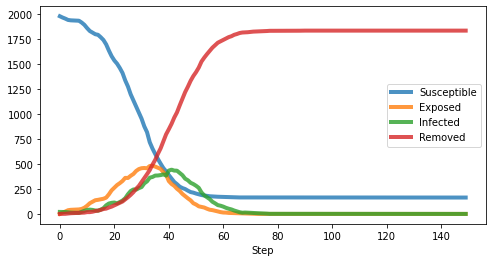

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1062                         14           15  0.266438
588                          13           19  0.299436
1308                         12           15  0.092880
1912                         11           16  0.131858
581                          10           12  0.207457
284                          10           12  0.599781
1831                          9           10  0.370995
141                           9           13  0.190403
349                           9           14  0.257757
1373                          9           15  0.405575
1271                          9           11  0.414275
1214                          9           16  0.629657
186                           9           11  0.512900
1978                          9           12  0.333773
158                           8           10  0.403727
1006                          8           14  0.071837
1610                          8           10  0.250054
1682                          8           10  0.119957
623                           8           11  0.524112
356                           7            8  0.592885

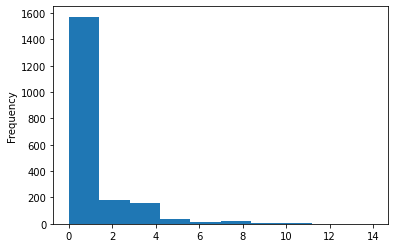

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

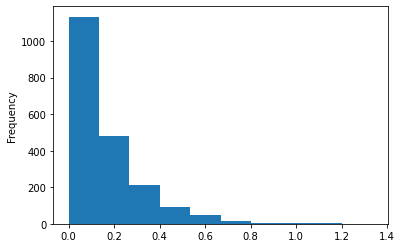

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      50.983133              668        41400                 20   
1      50.935528              451        41400                 20   
2      52.408968              498        41400                 20   
3      51.735893              606        41400                 20   
4      49.057348              609        41400                 26   
..           ...              ...          ...                ...   
95     51.241346              467        41400                 20   
96     51.248711              645        41400                 21   
97     54.041232              490        41400                 24   
98     52.559093              426        41400                 20   
99     54.619897              436        41400                 20   

    max_2_trans  num_of_S  
0            11      1178  
1            11      1445  
2            13      1384  
3            10      1282  
4            14      1255  
..          ...       ...  
95           11      1430  
96           12      1201  
97           11      1405  
98           10      1505  
99           11      1469  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  51.854657409191134 0.13169475804031103
Average_found_positives:  468.8 12.651937209436158
Average_total_tests:  41400.0 0.0
Average_max_outbreak_size:  21.08 0.22232926714740692
Average_max_2_trans: 12.01 0.18173962949586128
Average_number_of_uninfected: 1426.36 15.49895741035767


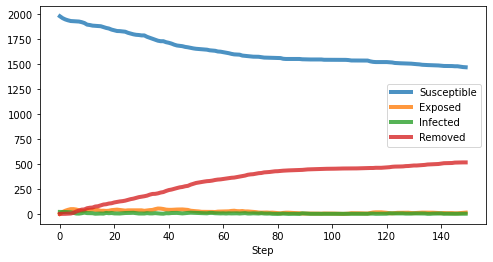

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


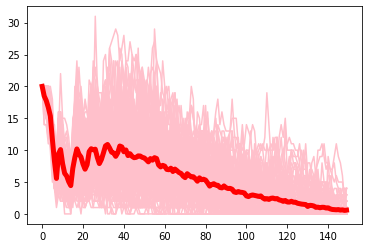

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

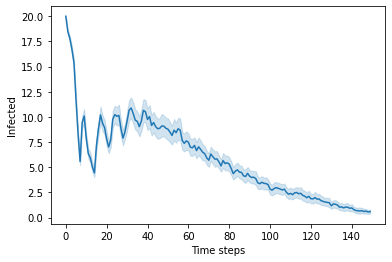

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
614                          11           12  0.414043
946                           9           11  0.333443
1996                          9           15  0.163775
651                           8            9  0.751665
885                           8           12  0.254238
1931                          8           12  0.463281
1823                          8           16  0.103442
1334                          8           13  0.183519
1124                          7            8  0.587456
672                           7           10  0.594516
1878                          7            9  0.343071
1975                          7           10  0.315026
516                           7           11  0.310994
96                            7           13  0.368060
1457                          6           10  0.262656
605                           6           12  0.108687
669                           6           16  0.131029
1890                          6            7  0.520629
1297                          6            7  0.110526
967                           6           11  0.191340

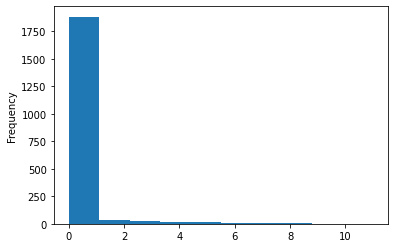

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

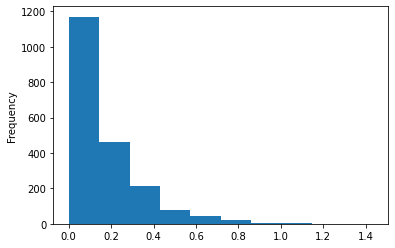

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      52.225636              559         5896                 20   
1      54.426490              797         6710                 20   
2      53.106897              560         5958                 20   
3      51.683397              355         5353                 20   
4      52.358165              669         6318                 20   
..           ...              ...          ...                ...   
95     61.634290              571         6098                 20   
96     59.105071              656         6201                 23   
97     59.044013              671         6322                 21   
98     57.912973              591         5997                 20   
99     62.270811              569         5928                 20   

    max_2_trans  num_of_S  
0            16      1389  
1            14      1134  
2            11      1396  
3            12      1616  
4            13      1272  
..          ...       ...  
95           12      1362  
96           11      1299  
97           11      1279  
98           12      1360  
99           10      1388  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  53.23312158346176 0.22775146928439982
Average_found_positives:  519.72 14.838702331022308
Average_total_tests:  5813.61 49.4262309105216
Average_max_outbreak_size:  20.59 0.17927744989374442
Average_max_2_trans: 11.27 0.17399349807891495
Average_number_of_uninfected: 1437.18 15.788458769082888


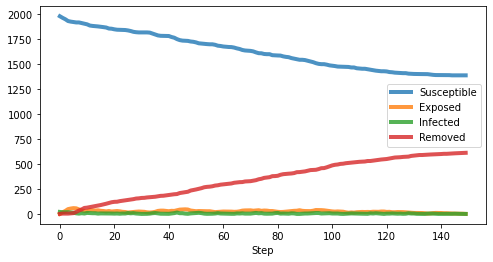

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


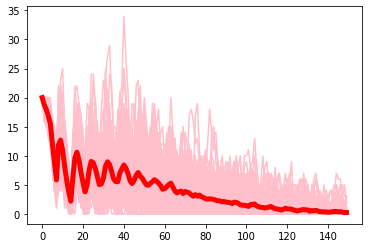

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


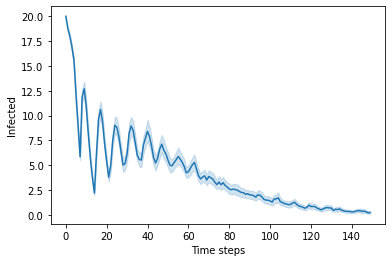

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
535                          10           11  0.470283
539                           9           10  0.385741
1291                          9           10  0.199951
1672                          8           18  0.154327
282                           8           10  0.445530
1985                          8           16  0.153990
1240                          7           12  0.298475
1144                          7           11  0.318212
946                           7           15  0.161492
1799                          7           10  0.471795
1945                          7           13  0.110960
1349                          7           10  0.287893
1278                          7           10  0.262078
333                           7           10  0.466817
1632                          6            9  0.258137
1641                          6            7  0.125894
1913                          6            9  0.649734
627                           6           11  0.508489
717                           6           15  0.046427
179                           6           11  0.351657

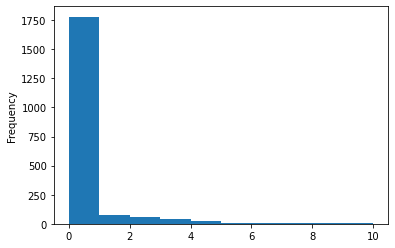

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

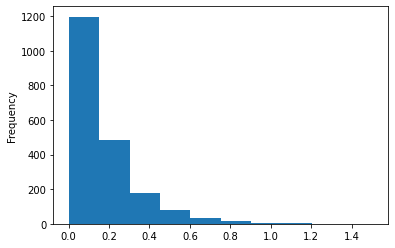

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      62.432885              855         6813                 23   
1      58.774751              774         6724                 21   
2      55.015436              667         6370                 20   
3      56.084899              159         4557                 20   
4      55.774723              494         5873                 20   
..           ...              ...          ...                ...   
95     50.793843              578         6161                 22   
96     51.550440              668         6237                 20   
97     53.322787              684         6494                 21   
98     51.345993              563         5999                 20   
99     51.760034              608         6293                 21   

    max_2_trans  num_of_S  
0            12      1080  
1            11      1164  
2            12      1265  
3            10      1822  
4            11      1454  
..          ...       ...  
95           10      1369  
96           14      1278  
97           10      1256  
98           11      1392  
99           15      1337  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  54.502043149471284 0.2675934280378979
Average_found_positives:  662.99 13.637911322945508
Average_total_tests:  6344.11 45.198446596619604
Average_max_outbreak_size:  21.69 0.2754958798203338
Average_max_2_trans: 11.6 0.18257418583505539
Average_number_of_uninfected: 1279.0 14.489076345072288


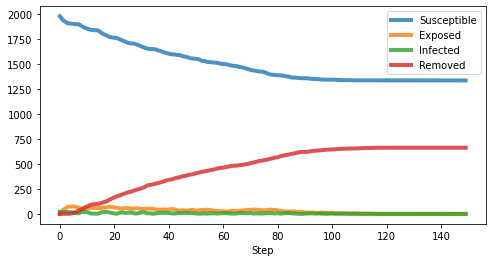

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


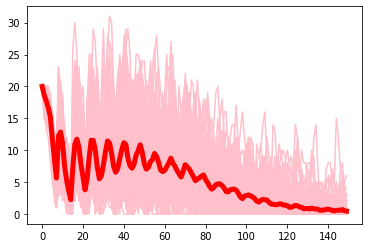

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


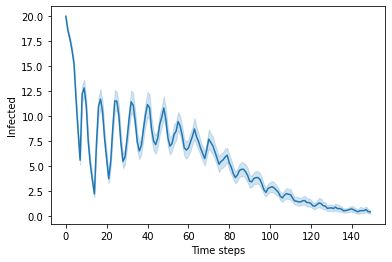

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
528                          15           15  0.246592
1700                         10           12  0.691351
14                           10           12  0.329698
614                           9           10  0.438781
867                           9           11  0.373090
1829                          8            9  0.696587
208                           7            7  0.419073
291                           7           12  0.456080
1607                          7           11  0.291374
1049                          7           15  0.154415
5                             7           11  0.295735
1902                          6            8  0.333605
1847                          6           11  0.318535
318                           6            8  0.112189
1811                          6           11  0.301088
788                           6            7  0.265671
1768                          6            7  1.272740
407                           6            8  0.675947
1360                          6            9  0.450943
1297                          6           11  0.172460

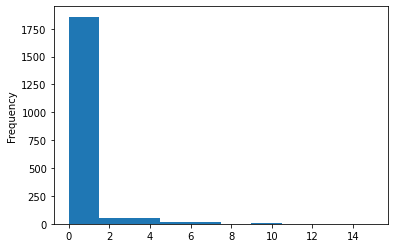

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

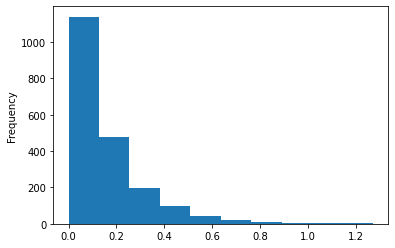

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      62.570058              716         6910                 21   
1      61.027264              604         6445                 20   
2      59.243556              572         6199                 25   
3      56.656825              380         5386                 20   
4      61.681303              706         6885                 23   
..           ...              ...          ...                ...   
95     55.842564              268         5049                 20   
96     58.587199              513         5901                 20   
97     62.771675              660         6687                 21   
98     54.579673              195         4775                 20   
99     60.503114              622         6601                 23   

    max_2_trans  num_of_S  
0            13      1231  
1            13      1324  
2            10      1372  
3            14      1577  
4            10      1235  
..          ...       ...  
95           12      1697  
96           11      1455  
97           13      1283  
98           10      1786  
99           11      1322  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  59.47289081335068 0.27178490395047666
Average_found_positives:  514.79 15.650896608388436
Average_total_tests:  5977.07 63.5126699441485
Average_max_outbreak_size:  20.65 0.17371461561068396
Average_max_2_trans: 11.55 0.17313216764872863
Average_number_of_uninfected: 1441.58 16.592679291199662


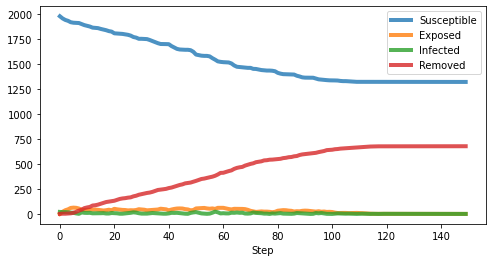

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


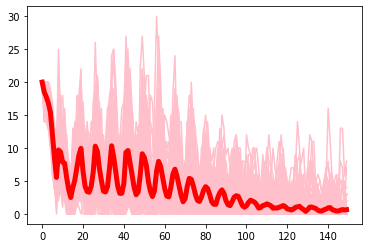

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


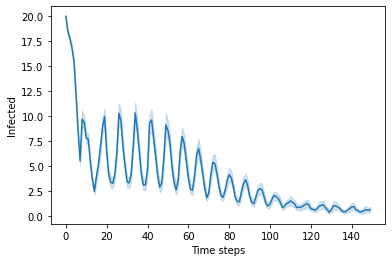

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
897                          11           11  0.826909
780                          10           12  0.536231
942                          10           11  0.501020
282                           9            9  0.425343
297                           8           13  0.534160
1811                          8           11  0.457852
309                           8           12  0.421046
321                           8            9  0.526140
1246                          7           17  0.370819
1495                          7            7  0.561693
855                           7           10  0.325485
864                           7            7  0.234933
1600                          7           14  0.296966
1198                          7            9  0.512167
1256                          7            9  0.641694
634                           6           18  0.149903
1217                          6            9  0.235115
912                           6           12  0.208517
1333                          6           14  0.490787
239                           6           11  0.423266

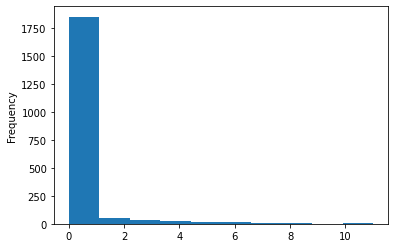

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

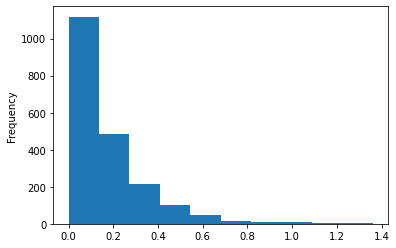

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(498, 112), (405, 113), (340, 114), (870, 115), (1276, 121)]

In [ ]:
group_df

Group  Degree  Intra_C  \
95   [1139, 495, 1204, 243, 644, 719, 1474, 46, 434...      62        7   
99   [1024, 113, 1741, 96, 643, 257, 1252, 83, 419,...      59        6   
10   [902, 1391, 1853, 523, 834, 1817, 1905, 1862, ...      44        9   
89   [172, 740, 1417, 1606, 1899, 192, 895, 1475, 1...      58        7   
73   [812, 1629, 873, 1075, 996, 1963, 1709, 327, 8...      47        8   
..                                                 ...     ...      ...   
174  [1589, 950, 1102, 1816, 479, 777, 1596, 448, 4...      51        7   
160  [398, 1996, 560, 658, 268, 374, 417, 467, 879,...      69        7   
75   [1545, 234, 735, 855, 1575, 949, 1248, 871, 14...      58        8   
168  [1486, 99, 359, 1870, 378, 776, 1497, 1672, 24...      54        8   
151  [1927, 242, 401, 168, 614, 354, 1604, 1935, 95...      53        8   

        order  record  flag  
95   0.000019      20     1  
99   0.000019      20     1  
10   0.000019      20     1  
89   0.000019      20     1  
73   0.000019      20     1  
..        ...     ...   ...  
174  0.000021      20     0  
160  0.000021      20     0  
75   0.000020      20     0  
168  0.000020      20     0  
151  0.000019      20     0  

[200 rows x 6 columns]

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
897                          11           11  0.826909
780                          10           12  0.536231
942                          10           11  0.501020
282                           9            9  0.425343
297                           8           13  0.534160
1811                          8           11  0.457852
309                           8           12  0.421046
321                           8            9  0.526140
1246                          7           17  0.370819
1495                          7            7  0.561693
855                           7           10  0.325485
864                           7            7  0.234933
1600                          7           14  0.296966
1198                          7            9  0.512167
1256                          7            9  0.641694
634                           6           18  0.149903
1217                          6            9  0.235115
912                           6           12  0.208517
1333                          6           14  0.490787
239                           6           11  0.423266

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      56.926383              371         5207                 20   
1      58.746942              320         4897                 20   
2      57.512938              421         5425                 20   
3      54.921500              191         4489                 20   
4      56.192717              254         4808                 20   
..           ...              ...          ...                ...   
95     55.645656              277         4817                 20   
96     60.900918              471         5698                 20   
97     55.820115              306         4933                 20   
98     56.687485              335         5012                 20   
99     56.106064              292         4869                 20   

    max_2_trans  num_of_S  
0            12      1587  
1            12      1652  
2            15      1540  
3            15      1785  
4            11      1728  
..          ...       ...  
95           10      1701  
96            9      1477  
97            9      1660  
98            9      1628  
99           11      1689  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  57.49699123620987 0.25980295343994614
Average_found_positives:  349.23 13.477784601995157
Average_total_tests:  5096.65 45.17824714562879
Average_max_outbreak_size:  20.5 0.26495663834299416
Average_max_2_trans: 10.89 0.19378995189262377
Average_number_of_uninfected: 1614.89 14.90942956316538


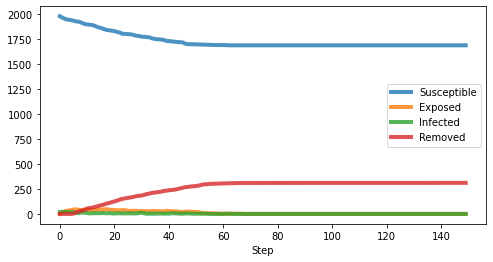

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


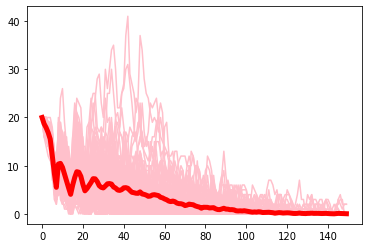

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


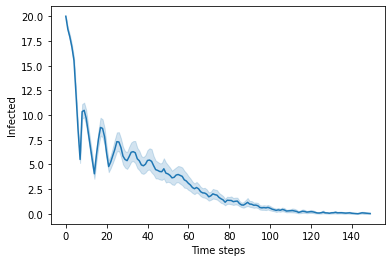

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1394                         11           13  0.322189
1460                          9           10  0.552507
912                           9           10  0.274911
1766                          8            9  0.237972
1266                          8           13  0.231372
612                           7            7  0.342211
1108                          7           15  0.378295
262                           7           11  0.211354
517                           7           12  0.453379
1401                          6            9  0.176029
431                           6            8  0.508493
1134                          6            8  0.178051
1363                          6            8  0.640692
1738                          6            9  0.231874
6                             6            8  0.240349
56                            6            7  0.270710
281                           5            8  0.256038
303                           5            5  0.308751
1443                          5           12  0.058419
1467                          5            7  0.209466

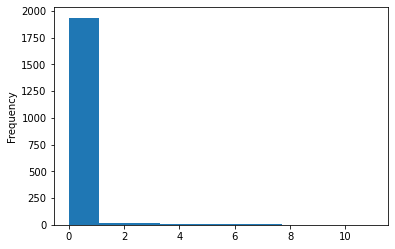

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

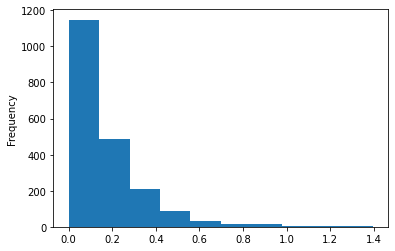

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(461, 61), (1973, 63), (61, 64), (9, 66), (1768, 71)]

In [ ]:
group_df

Group  Degree  Intra_C  \
162  [658, 188, 717, 578, 902, 1923, 1027, 1769, 14...      53        7   
111  [1001, 926, 1399, 964, 1392, 1571, 1955, 281, ...      73        8   
34   [1295, 1659, 1596, 1621, 1382, 1409, 103, 213,...      66        9   
112  [545, 1025, 427, 81, 358, 22, 472, 280, 575, 1...      56        7   
165  [1446, 99, 212, 1950, 357, 456, 245, 641, 486,...      58        8   
..                                                 ...     ...      ...   
58   [657, 1584, 434, 1339, 909, 56, 131, 228, 1944...      42        7   
65   [446, 488, 595, 971, 1056, 1353, 1439, 881, 14...      40        8   
19   [1055, 1163, 1476, 187, 239, 1159, 1452, 1348,...      68        9   
173  [1272, 1701, 1362, 105, 484, 1350, 1030, 1247,...      75        7   
109  [235, 1009, 206, 828, 669, 31, 129, 64, 736, 1...      55        8   

        order  record  flag  
162  0.000004      18     1  
111  0.000004      21     1  
34   0.000004      22     1  
112  0.000004      22     1  
165  0.000004      19     1  
..        ...     ...   ...  
58   0.000004      17     0  
65   0.000004      19     0  
19   0.000004      22     0  
173  0.000004      22     0  
109  0.000004      20     0  

[200 rows x 6 columns]

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1394                         11           13  0.322189
1460                          9           10  0.552507
912                           9           10  0.274911
1766                          8            9  0.237972
1266                          8           13  0.231372
612                           7            7  0.342211
1108                          7           15  0.378295
262                           7           11  0.211354
517                           7           12  0.453379
1401                          6            9  0.176029
431                           6            8  0.508493
1134                          6            8  0.178051
1363                          6            8  0.640692
1738                          6            9  0.231874
6                             6            8  0.240349
56                            6            7  0.270710
281                           5            8  0.256038
303                           5            5  0.308751
1443                          5           12  0.058419
1467                          5            7  0.209466

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

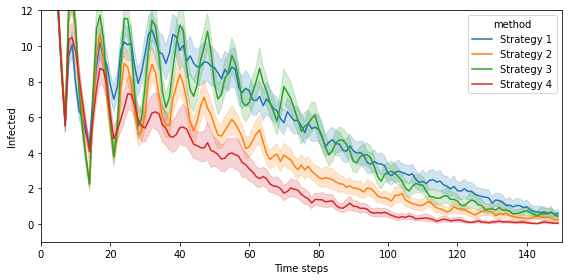

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 150)
plt.ylim(top = 12)
plt.tight_layout()

# ER

In [ ]:
G_temp = nx.erdos_renyi_graph(n=2000, p=0.003)
[G_temp.add_edge(i, random.randint(0, 1999)) for i in list(nx.isolates(G_temp))]
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
print(list(nx.isolates(G)))

# of nodes:  2000
Average degree:  6.199
[]


In [ ]:
def network_gen():
  G_temp = nx.erdos_renyi_graph(n=2000, p=0.003)
  [G_temp.add_edge(i, random.randint(0, 1999)) for i in list(nx.isolates(G_temp))]
  G = nx.convert_node_labels_to_integers(G_temp)
  return G

##Testing Strategy _0

In [ ]:
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = network_gen())
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


10.159562587738037
      Susceptible  Exposed  Infected  Removed
Step                                         
0            1980        0        20        0
1            1963       17        19        1
2            1947       33        19        1
3            1931       49        18        2
4            1921       59        16        4
5            1916       64        15        5
6            1915       65        13        7
7            1911       69        11        9
8            1905       58        23       14
9            1896       51        39       14
10           1875       56        50       19
11           1850       71        57       22
12           1824       92        54       30
13           1809      106        45       40
14           1791      120        42       47
15           1774      131        44       51
16           1753      143        45       59
17           1728      147        63       62
18           1682      168        77       73
19           16

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  440
number_of_uninfected: 127


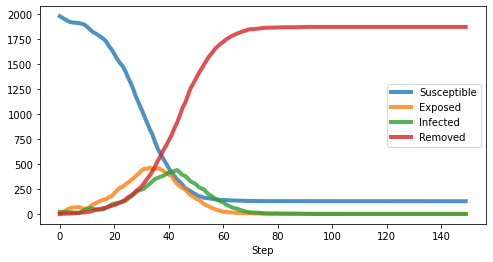

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
578                          11           11  0.355982
456                          10           12  0.586623
377                          10           10  0.226397
1041                         10           10  0.230072
541                           9           13  0.364345
746                           8           15  0.304869
442                           8           10  0.269750
351                           8           13  0.439111
621                           8            9  0.430533
1681                          8           11  0.171019
1975                          8           13  0.171057
178                           8           12  0.535417
760                           7            8  0.267519
937                           7            8  0.518526
1915                          7           10  0.195629
1664                          7           10  0.279261
923                           7           10  0.211948
787                           7            9  0.305710
447                           7            9  0.312479
264                           7            9  0.186564

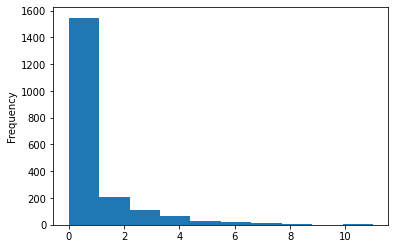

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

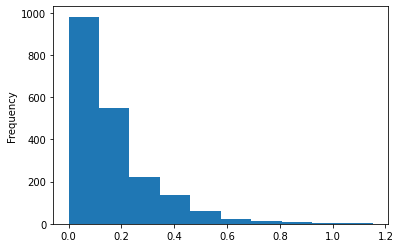

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      95.063575              585        41400                 20   
1      88.419314              620        41400                 20   
2      53.106947              342        41400                 20   
3      49.258591              215        41400                 20   
4      50.927025              266        41400                 20   
..           ...              ...          ...                ...   
95     50.469399              462        41400                 20   
96     48.916987              370        41400                 20   
97     48.373668              385        41400                 20   
98     47.774554              146        41400                 20   
99     50.103308              286        41400                 23   

    max_2_trans  num_of_S  
0             9      1296  
1            11      1264  
2             9      1588  
3            11      1734  
4            10      1681  
..          ...       ...  
95           11      1419  
96           11      1537  
97           10      1521  
98           11      1820  
99            8      1634  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  49.439114439487454 0.6249225884656759
Average_found_positives:  379.11 12.7975447061165
Average_total_tests:  41400.0 0.0
Average_max_outbreak_size:  20.27 0.07895146188218008
Average_max_2_trans: 9.96 0.16324982404433105
Average_number_of_uninfected: 1531.94 15.666098119922214


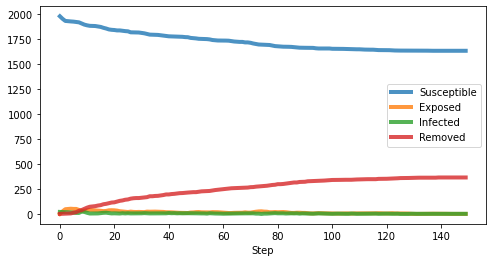

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


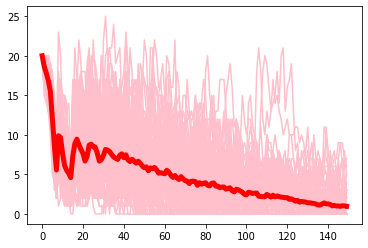

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

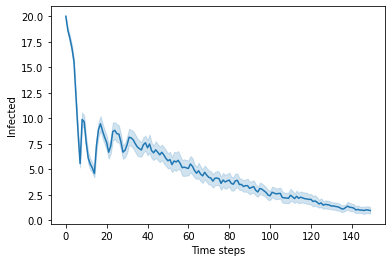

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1826                          8            9  0.450534
1401                          7           13  0.135870
643                           7            8  0.129893
427                           7           10  0.514765
79                            7            7  0.501058
1014                          7            8  0.427702
1402                          7            7  0.382422
885                           6            8  0.163323
1761                          6            9  0.373770
572                           6            6  0.666688
390                           6            8  0.232581
1699                          6           10  0.197903
1992                          5            6  0.154236
112                           5            7  0.154933
1290                          5           13  0.249906
1900                          5            6  0.463492
597                           5           12  0.049027
652                           5            5  0.687857
670                           5            7  0.088708
1930                          5            9  0.405072

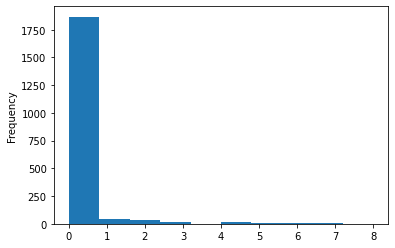

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

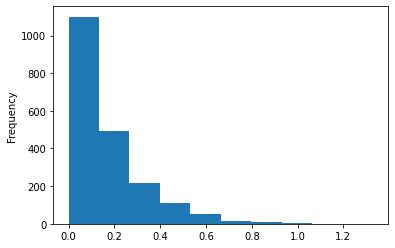

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      48.744183              657         6287                 20   
1      48.785650              430         5606                 20   
2      48.097586              307         5065                 20   
3      50.649562              561         6054                 20   
4      49.082961              418         5552                 20   
..           ...              ...          ...                ...   
95     50.609761              410         5378                 20   
96     48.247561              473         5742                 20   
97     48.175582              375         5403                 20   
98     47.751971              469         5571                 20   
99     50.586641              607         6189                 20   

    max_2_trans  num_of_S  
0            11      1297  
1             8      1535  
2             8      1663  
3            12      1399  
4            11      1540  
..          ...       ...  
95            9      1539  
96            9      1482  
97           11      1599  
98           11      1498  
99            9      1342  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  48.93828382492065 0.11301145664971093
Average_found_positives:  411.79 13.742812960991941
Average_total_tests:  5481.31 48.25445328274024
Average_max_outbreak_size:  20.18 0.06416519085276469
Average_max_2_trans: 9.58 0.14576860035166989
Average_number_of_uninfected: 1553.12 14.580880520999983


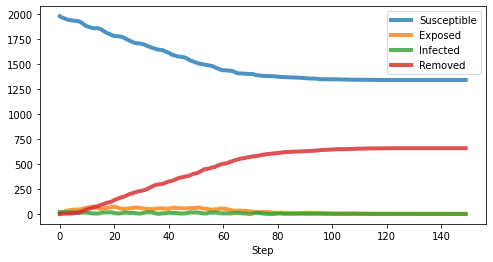

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


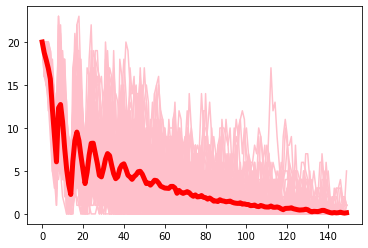

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


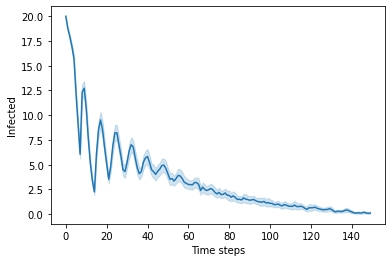

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1490                          9            9  0.376027
1102                          9           11  0.509277
1841                          9           12  0.711480
1062                          9           10  0.639524
96                            8           10  0.668834
923                           8            9  0.451530
1771                          8           14  0.260212
708                           8           11  0.247346
1038                          8           10  0.513094
434                           7           13  0.151718
1024                          7           11  0.311459
244                           7            9  0.479988
197                           7            9  0.491529
1703                          7           11  0.533970
1968                          6            9  0.594616
1560                          6           10  0.251918
476                           6            8  0.248649
1195                          6           10  0.268555
1819                          6           10  0.426074
224                           6            7  0.088549

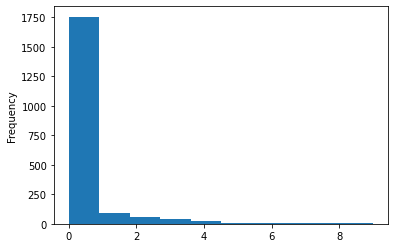

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

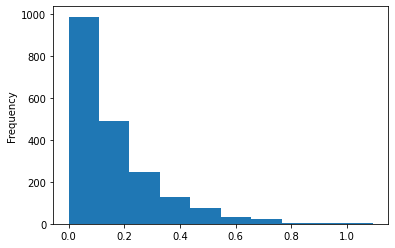

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      48.503465              530         5979                 20   
1      49.478531              712         6721                 21   
2      50.893295              518         5886                 20   
3      49.105473              318         5086                 20   
4      48.735842              543         6083                 20   
..           ...              ...          ...                ...   
95     50.968951              161         4664                 20   
96     51.069304              733         6624                 25   
97     54.181524              622         6329                 20   
98     52.464864              445         5776                 20   
99     52.921201              681         6519                 20   

    max_2_trans  num_of_S  
0            10      1413  
1            12      1247  
2            12      1442  
3            11      1652  
4            11      1410  
..          ...       ...  
95            6      1817  
96            8      1214  
97            8      1328  
98            9      1492  
99           11      1262  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  51.072261791229245 0.1980548350369139
Average_found_positives:  566.35 14.428236730505748
Average_total_tests:  6069.54 51.75482297342056
Average_max_outbreak_size:  20.9 0.19306145983268458
Average_max_2_trans: 9.84 0.14544949486180955
Average_number_of_uninfected: 1382.81 15.37057200752086


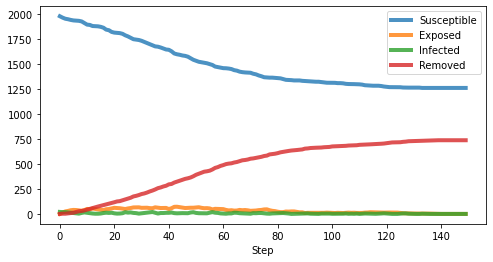

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


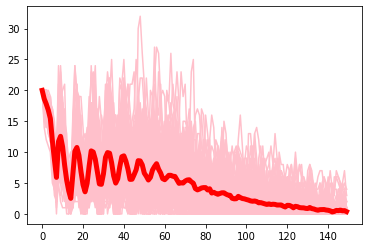

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


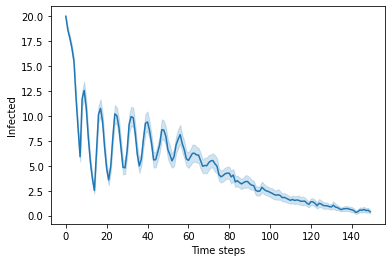

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
545                          11           15  0.279350
989                           8           12  0.226367
289                           7            8  0.305312
1829                          7            7  0.206479
1191                          7            8  0.174558
257                           7            9  0.427105
741                           7           12  0.124058
783                           7            9  0.466464
1342                          7            9  0.462984
561                           6            9  0.428806
1579                          6            9  0.375082
1620                          6           10  0.480890
165                           6           11  0.400451
1844                          6           13  0.296613
1419                          6            8  0.259194
793                           6            8  0.627424
850                           6            7  0.457645
691                           6            9  0.472272
269                           5            7  0.213410
944                           5           10  0.359099

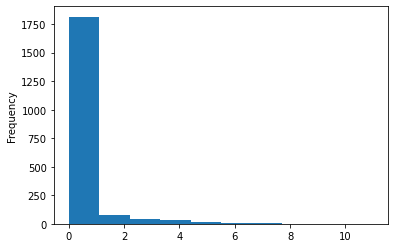

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

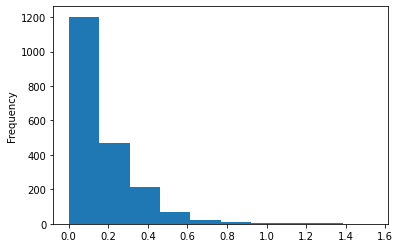

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      63.264902              640         6501                 23   
1      56.407198              280         5022                 20   
2      59.999864              489         5868                 20   
3      60.787017              480         5961                 20   
4      54.295407              141         4420                 20   
..           ...              ...          ...                ...   
95     56.988404              419         5699                 20   
96     51.308290              126         4451                 20   
97     55.940438              441         5625                 20   
98     57.169162              549         6032                 23   
99     54.824512              335         5212                 20   

    max_2_trans  num_of_S  
0             9      1312  
1             8      1699  
2            12      1463  
3            11      1476  
4             8      1849  
..          ...       ...  
95           11      1535  
96            7      1856  
97            9      1513  
98            9      1400  
99            9      1626  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  58.14440391540527 0.2815504917459407
Average_found_positives:  405.52 15.657795554169226
Average_total_tests:  5577.25 67.40709037878236
Average_max_outbreak_size:  20.25 0.09885710532241612
Average_max_2_trans: 9.59 0.14913555626145675
Average_number_of_uninfected: 1558.89 16.712131292065422


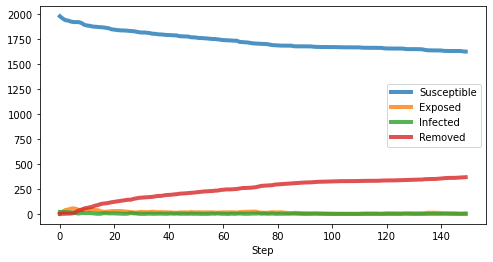

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


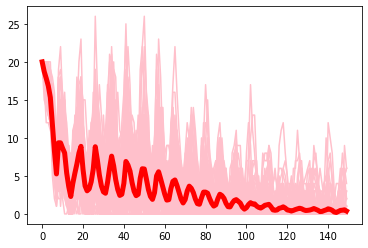

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


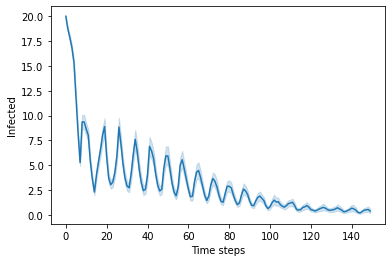

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1439                          9           11  0.338897
1011                          8            8  0.484532
380                           8           11  0.711230
650                           7           10  0.433229
1691                          7            8  0.270001
1949                          7           11  0.458552
214                           7            8  0.666467
977                           6            6  0.206471
565                           6            6  0.664506
1658                          6            7  0.268220
1225                          6            8  0.481920
236                           6           10  0.288758
1507                          6            9  0.391798
135                           5            6  0.534680
1864                          5            6  0.711124
1936                          5            8  0.314222
1759                          5            8  0.288867
1403                          5           10  0.456334
215                           5            6  0.378545
1218                          5            7  0.123424

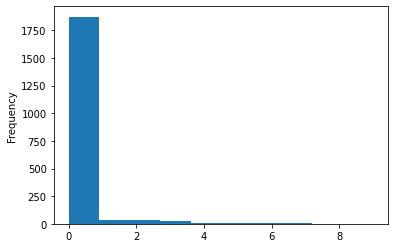

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

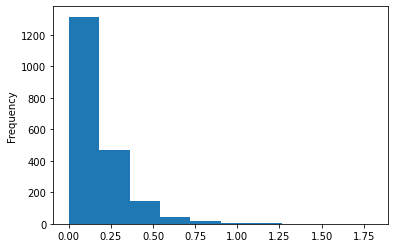

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(1364, 146), (472, 146), (1083, 147), (100, 148), (1225, 148)]

In [ ]:
group_df

Group  Degree  Intra_C  \
7    [997, 1672, 482, 1606, 650, 1178, 1502, 1822, ...      48        9   
190  [1016, 1433, 1501, 1773, 393, 597, 1449, 1658,...      44        6   
164  [1278, 1592, 689, 1003, 1857, 80, 339, 1601, 8...      66        7   
180  [1953, 938, 950, 1815, 1995, 291, 1140, 425, 1...      65        7   
157  [984, 1971, 356, 1053, 63, 191, 424, 437, 1979...      60        6   
..                                                 ...     ...      ...   
195  [88, 1656, 1795, 1958, 220, 1032, 1671, 1782, ...      63        6   
93   [1224, 459, 556, 1106, 1227, 107, 679, 522, 77...      63        6   
119  [710, 487, 829, 816, 1509, 568, 866, 640, 1599...      69        7   
1    [572, 587, 769, 1241, 657, 1341, 1222, 557, 39...      68       10   
81   [179, 732, 1959, 664, 1153, 144, 503, 1693, 18...      65       10   

        order  record  flag  
7    0.000003      20     1  
190  0.000003      20     1  
164  0.000002      20     1  
180  0.000002      20     1  
157  0.000002      20     1  
..        ...     ...   ...  
195  0.000003      20     0  
93   0.000003      20     0  
119  0.000003      20     0  
1    0.000003      20     0  
81   0.000002      20     0  

[200 rows x 6 columns]

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1439                          9           11  0.338897
1011                          8            8  0.484532
380                           8           11  0.711230
650                           7           10  0.433229
1691                          7            8  0.270001
1949                          7           11  0.458552
214                           7            8  0.666467
977                           6            6  0.206471
565                           6            6  0.664506
1658                          6            7  0.268220
1225                          6            8  0.481920
236                           6           10  0.288758
1507                          6            9  0.391798
135                           5            6  0.534680
1864                          5            6  0.711124
1936                          5            8  0.314222
1759                          5            8  0.288867
1403                          5           10  0.456334
215                           5            6  0.378545
1218                          5            7  0.123424

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      51.615219              235         4610                 20   
1      51.997656              204         4561                 20   
2      52.835377              144         4401                 20   
3      58.736394              554         5642                 20   
4      51.752932              184         4481                 20   
..           ...              ...          ...                ...   
95     52.121256              127         4368                 20   
96     54.185528              282         4863                 20   
97     53.933942              172         4468                 20   
98     54.310664              355         5204                 20   
99     53.767704              275         4878                 20   

    max_2_trans  num_of_S  
0             9      1739  
1             9      1773  
2             7      1835  
3            11      1398  
4             8      1794  
..          ...       ...  
95            7      1852  
96            8      1692  
97           10      1794  
98            8      1614  
99            8      1695  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  54.0000807261467 0.18950831818096786
Average_found_positives:  274.02 11.391871814339531
Average_total_tests:  4848.27 38.43779930161865
Average_max_outbreak_size:  20.12 0.06556668284265951
Average_max_2_trans: 9.43 0.1465116260426338
Average_number_of_uninfected: 1696.75 12.37215327934781


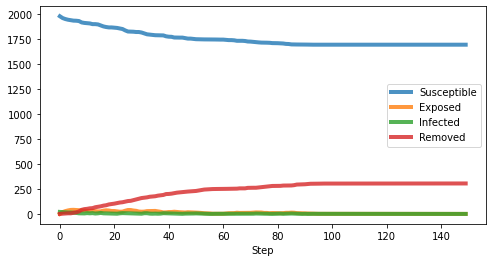

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


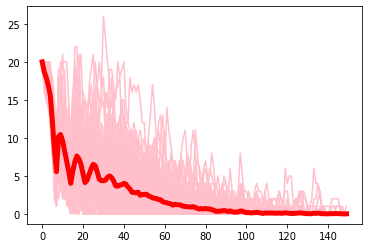

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


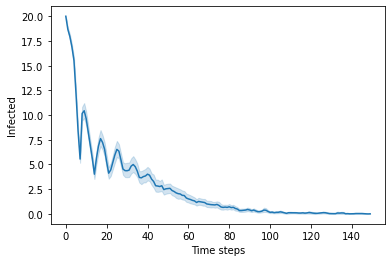

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1660                          8            8  0.819757
1555                          7            8  0.440319
485                           7           10  0.305375
85                            7           11  0.469974
121                           7            9  0.311336
1719                          6            6  0.402399
1197                          6            9  0.150306
413                           6            7  0.521657
496                           5            9  0.418937
871                           5            6  0.308726
1089                          5            8  0.579188
961                           5            8  0.320449
1776                          5           11  0.105706
1140                          5            7  0.515173
724                           5            8  0.338386
274                           5           11  0.309730
1718                          5            7  0.475936
1291                          5            6  0.310570
5                             5            7  0.174861
1809                          4           13  0.084638

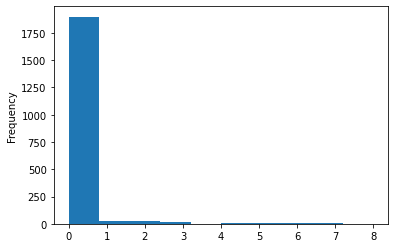

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

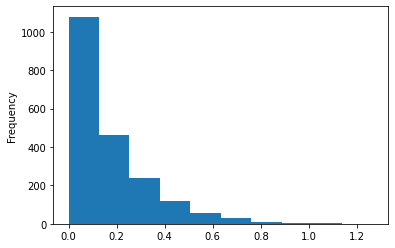

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(1702, 91), (352, 91), (79, 93), (1150, 95), (587, 98)]

In [ ]:
group_df

Group  Degree  Intra_C  \
17   [1309, 1462, 1470, 1752, 1453, 1771, 3, 297, 9...      60        9   
139  [1018, 864, 1137, 1097, 1434, 839, 971, 847, 1...      76        7   
114  [345, 369, 1262, 490, 711, 677, 883, 257, 1691...      47        8   
3    [927, 1846, 1701, 41, 190, 1234, 1690, 1512, 2...      59        9   
117  [1896, 285, 800, 479, 1030, 466, 842, 777, 108...      69        7   
..                                                 ...     ...      ...   
145  [1971, 951, 1528, 991, 1831, 1145, 1766, 1400,...      53        7   
155  [1853, 1266, 1747, 1723, 1845, 1272, 1536, 158...      63        6   
33   [1602, 1658, 1794, 1986, 1669, 136, 158, 1774,...      52        9   
157  [1731, 163, 1071, 1954, 1773, 166, 216, 1734, ...      48        8   
15   [1282, 1378, 1687, 284, 382, 1374, 1999, 1906,...      56        9   

        order  record  flag  
17   0.000003      20     1  
139  0.000003      22     1  
114  0.000003      19     1  
3    0.000003      20     1  
117  0.000003      19     1  
..        ...     ...   ...  
145  0.000003      20     0  
155  0.000003      20     0  
33   0.000003      22     0  
157  0.000003      19     0  
15   0.000003      21     0  

[200 rows x 6 columns]

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1660                          8            8  0.819757
1555                          7            8  0.440319
485                           7           10  0.305375
85                            7           11  0.469974
121                           7            9  0.311336
1719                          6            6  0.402399
1197                          6            9  0.150306
413                           6            7  0.521657
496                           5            9  0.418937
871                           5            6  0.308726
1089                          5            8  0.579188
961                           5            8  0.320449
1776                          5           11  0.105706
1140                          5            7  0.515173
724                           5            8  0.338386
274                           5           11  0.309730
1718                          5            7  0.475936
1291                          5            6  0.310570
5                             5            7  0.174861
1809                          4           13  0.084638

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

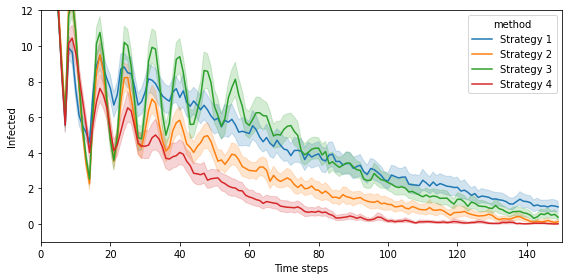

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 150)
plt.ylim(top = 12)
plt.tight_layout()

# Small World

In [ ]:
G_temp = nx.watts_strogatz_graph(n=2000, k=6, p=0.1)
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
print(list(nx.isolates(G)))

# of nodes:  2000
Average degree:  6.0
[]


In [ ]:
def network_gen():
  G_temp = nx.watts_strogatz_graph(n=2000, k=6, p=0.1)
  G = nx.convert_node_labels_to_integers(G_temp)
  return G

##Testing Strategy _0

In [ ]:
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = network_gen())
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


9.933391571044922
      Susceptible  Exposed  Infected  Removed
Step                                         
0            1980        0        20        0
1            1964       16        19        1
2            1951       29        17        3
3            1943       37        16        4
4            1940       40        15        5
5            1934       46        13        7
6            1933       47        10       10
7            1930       50         9       11
8            1921       43        20       16
9            1910       41        29       20
10           1899       44        35       22
11           1889       51        35       25
12           1883       51        37       29
13           1875       58        31       36
14           1870       60        28       42
15           1866       55        27       52
16           1856       54        34       56
17           1839       60        44       57
18           1830       59        48       63
19           182

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  174
number_of_uninfected: 133


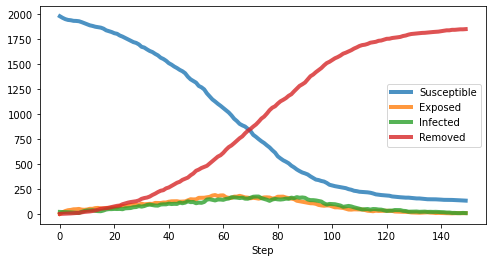

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
257                           7            7  0.432682
284                           7            8  0.370450
797                           7            8  0.328040
1448                          6            7  0.455639
1469                          6            6  0.261368
1229                          6            7  0.363988
1237                          6            7  0.326293
521                           6            7  0.604428
352                           6            7  0.426513
858                           6            7  0.193235
1104                          6            8  0.201218
1283                          6            8  0.569457
148                           6            7  0.290965
1364                          6            8  0.548401
1849                          6            7  0.148793
680                           6            7  0.222742
761                           6            7  0.119956
62                            5            6  0.321149
927                           5            6  0.294776
724                           5            6  0.908413

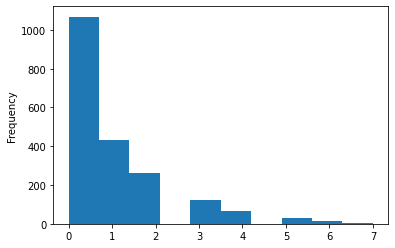

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

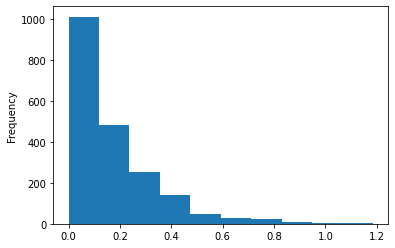

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      48.904146              106        41400                 20   
1      47.415617              147        41400                 20   
2      47.791046              123        41400                 20   
3      48.070423              125        41400                 20   
4      47.360679              119        41400                 20   
..           ...              ...          ...                ...   
95     47.765862              105        41400                 20   
96     46.348153               91        41400                 20   
97     46.344571               89        41400                 20   
98     46.193225              126        41400                 20   
99     48.201371               82        41400                 20   

    max_2_trans  num_of_S  
0             6      1871  
1             6      1817  
2             6      1849  
3             6      1841  
4             6      1852  
..          ...       ...  
95            6      1872  
96            6      1884  
97            6      1892  
98            7      1850  
99            7      1885  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  49.35604864358902 0.25655305830076747
Average_found_positives:  116.63 2.7859914725010353
Average_total_tests:  41400.0 0.0
Average_max_outbreak_size:  20.0 0.0
Average_max_2_trans: 6.48 0.06739001514626734
Average_number_of_uninfected: 1854.03 3.4285036639527413


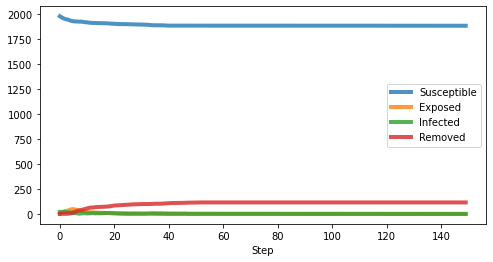

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


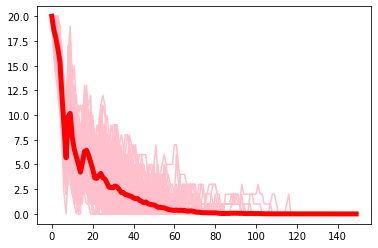

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

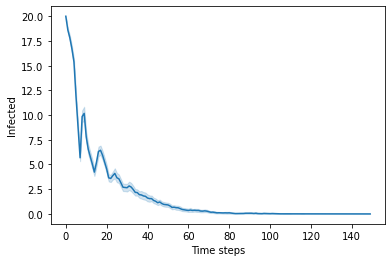

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
156                           7            7  0.280860
792                           6            6  0.834821
744                           6            6  0.685503
1131                          5            6  0.295578
1647                          5            6  0.160942
1539                          4            6  0.424258
1644                          4            6  0.458398
499                           4            6  0.172954
306                           3            6  0.117832
970                           3            6  0.115188
304                           3            6  0.112063
1978                          3            7  0.139350
1542                          3            6  0.195589
337                           3            6  0.148375
218                           2            6  0.127734
772                           2            6  0.219113
1999                          2            7  0.145977
1800                          2            6  0.279370
969                           2            6  0.582603
301                           2            6  0.044738

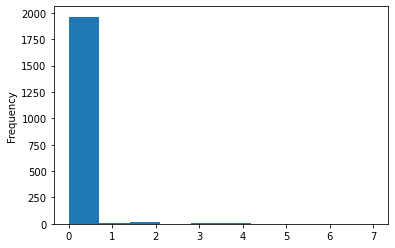

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

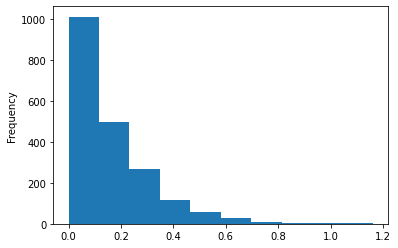

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      46.905174              116         4492                 20   
1      47.733952              119         4388                 20   
2      46.853097               82         4288                 20   
3      47.846708              170         4735                 20   
4      48.498582              146         4609                 20   
..           ...              ...          ...                ...   
95     48.690209              140         4571                 20   
96     47.417280              124         4488                 20   
97     46.972174              112         4424                 20   
98     47.255626              188         4745                 20   
99     48.612721              153         4532                 20   

    max_2_trans  num_of_S  
0             8      1862  
1             8      1859  
2             6      1905  
3             8      1817  
4             7      1839  
..          ...       ...  
95            6      1844  
96            8      1857  
97            7      1868  
98            6      1795  
99            6      1828  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  47.71075385808945 0.06517687902771016
Average_found_positives:  133.98 2.8535634288419525
Average_total_tests:  4525.53 14.029625616868575
Average_max_outbreak_size:  20.05 0.041132945334843116
Average_max_2_trans: 6.59 0.071201804539611
Average_number_of_uninfected: 1847.85 2.95372987966405


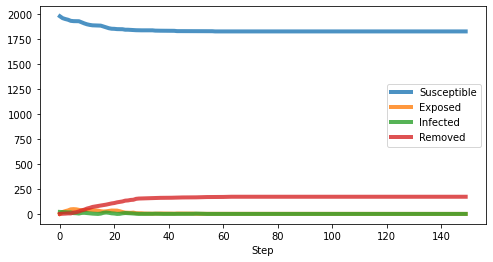

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


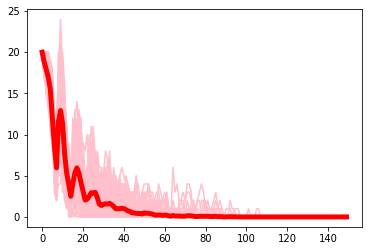

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


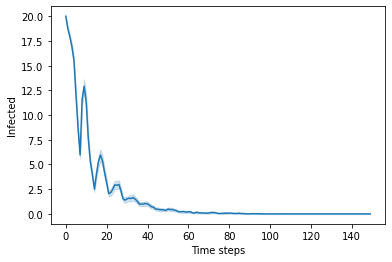

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1812                          6            6  0.230165
58                            6            7  0.606895
82                            6            6  0.509682
1568                          5            7  0.311293
225                           5            7  0.529566
244                           5            7  0.504742
88                            5            7  0.398008
1326                          4            8  0.148943
906                           4            7  0.203407
1526                          4            4  0.300393
1300                          4            5  0.146278
596                           4            8  0.365083
597                           4            7  0.166418
1482                          4            7  0.367995
1479                          4            7  0.344825
22                            3            6  0.134807
593                           3            6  0.858586
55                            3            6  0.351863
1570                          3            6  0.407521
1565                          3            5  0.038555

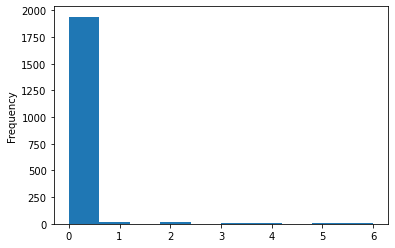

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

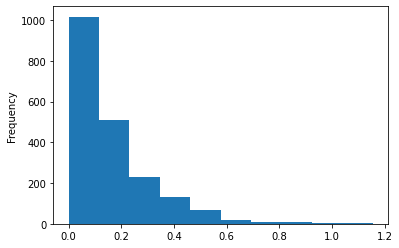

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      47.189139              147         4404                 20   
1      47.781117              132         4352                 20   
2      47.425727              206         4739                 20   
3      47.879080              207         4530                 20   
4      49.319025              177         4588                 20   
..           ...              ...          ...                ...   
95     47.864615              232         4697                 20   
96     47.850231              189         4686                 20   
97     48.221667              168         4666                 20   
98     48.506555              157         4498                 20   
99     47.822338              172         4646                 22   

    max_2_trans  num_of_S  
0             7      1841  
1             6      1844  
2             6      1776  
3             7      1774  
4             6      1797  
..          ...       ...  
95            7      1743  
96            6      1784  
97            6      1807  
98            6      1832  
99            6      1797  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  48.03696397781372 0.06481771229462438
Average_found_positives:  159.21 4.5996112044740505
Average_total_tests:  4497.67 16.47379955314413
Average_max_outbreak_size:  20.18 0.0857291954324485
Average_max_2_trans: 6.58 0.06989169110021938
Average_number_of_uninfected: 1818.56 4.8973569453844235


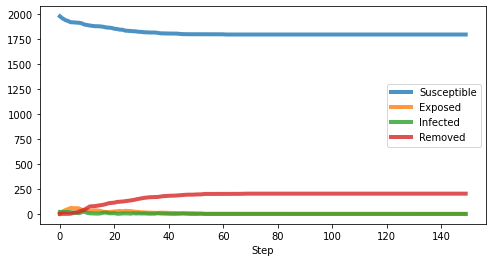

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


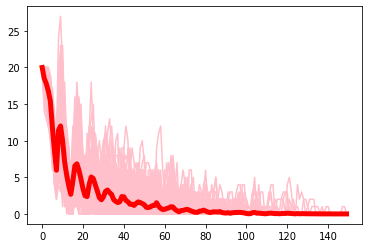

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


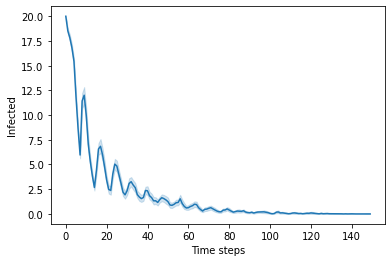

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1735                          6            6  0.349400
761                           6            6  0.381047
1996                          6            6  0.292922
468                           6            6  0.510633
1059                          6            6  0.220474
1842                          5            6  0.368913
4                             5            5  0.410742
1178                          5            7  0.356827
121                           5            5  0.502898
1462                          5            6  0.167798
874                           4            6  0.314913
156                           4            5  0.430190
153                           4            8  0.408611
932                           4            6  0.411952
1259                          4            7  0.432766
1778                          4            5  0.285168
1499                          4            6  0.323761
425                           3            6  0.351113
872                           3            6  0.175357
1137                          3            6  0.172466

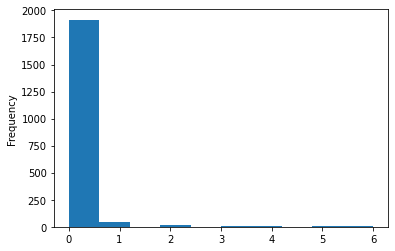

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

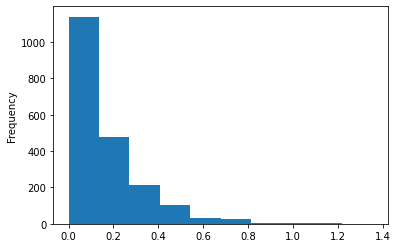

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      49.809510               97         4182                 20   
1      49.364608               72         4192                 20   
2      49.208128               72         4102                 20   
3      52.249570              154         4310                 20   
4      48.960006               81         4141                 20   
..           ...              ...          ...                ...   
95     52.730677               86         4170                 20   
96     52.930293               84         4170                 20   
97     55.491915               96         4142                 20   
98     53.201816              105         4212                 20   
99     53.523517               95         4131                 20   

    max_2_trans  num_of_S  
0             7      1887  
1             7      1914  
2             6      1917  
3             8      1829  
4             6      1905  
..          ...       ...  
95            6      1900  
96            7      1896  
97            7      1893  
98            7      1882  
99            7      1890  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  51.268493151664735 0.1594854595257793
Average_found_positives:  89.37 2.1371488133738024
Average_total_tests:  4162.15 5.418698919463783
Average_max_outbreak_size:  20.11 0.0802710056211727
Average_max_2_trans: 6.53 0.06883591968139771
Average_number_of_uninfected: 1895.96 2.247464115285258


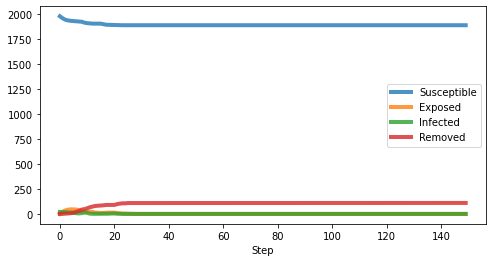

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


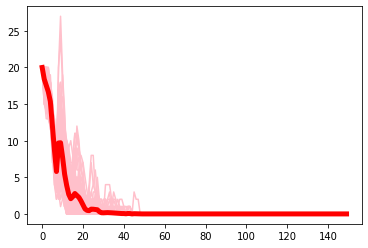

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


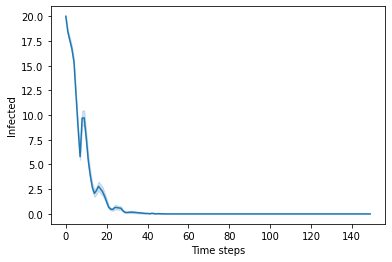

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
805                           7            8  0.384675
1260                          7            7  0.364070
366                           6            6  0.661627
1510                          6            6  0.257069
1243                          4            5  0.293981
1944                          4            6  0.077894
1507                          4            7  0.390943
1858                          4            7  0.154491
645                           4            6  0.457110
749                           4            8  0.239941
750                           4            5  0.278371
1976                          3            6  0.106243
118                           3            6  0.072615
1892                          3            5  0.327864
1158                          2            3  0.067288
1457                          2            6  0.267769
1241                          2            5  0.139305
108                           2            4  0.016058
1279                          2            6  0.094929
1890                          2            6  0.342710

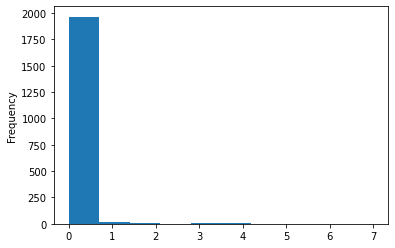

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

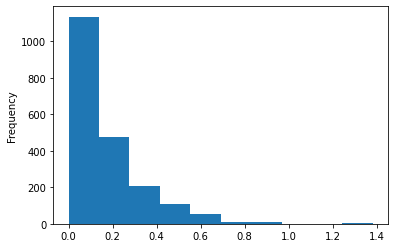

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(1892, 22), (1894, 24), (1893, 24), (1895, 24), (1888, 27)]

In [ ]:
group_df

Group  Degree  Intra_C  \
97   [758, 760, 765, 762, 763, 767, 764, 766, 783, ...      57       14   
191  [754, 751, 752, 753, 755, 893, 890, 892, 891, ...      56       15   
27   [1336, 1337, 1342, 1339, 1341, 1340, 1343, 139...      62       14   
73   [445, 446, 450, 448, 449, 453, 451, 452, 464, ...      62       14   
165  [1735, 1733, 1734, 1738, 1736, 1737, 1749, 174...      63       15   
..                                                 ...     ...      ...   
47   [124, 128, 126, 127, 131, 129, 130, 134, 132, ...      61       20   
155  [1571, 1575, 1573, 1574, 1579, 1576, 1577, 158...      58       18   
62   [324, 329, 326, 327, 331, 328, 330, 334, 332, ...      61       22   
120  [1048, 1046, 1047, 1051, 1049, 1050, 1054, 105...      63       22   
85   [586, 587, 591, 589, 590, 594, 592, 593, 597, ...      60       20   

            order  record  flag  
97   8.917071e-07      19     1  
191  8.869225e-07      21     1  
27   8.833354e-07      19     1  
73   8.833354e-07      19     1  
165  8.825104e-07      20     1  
..            ...     ...   ...  
47   9.093134e-07      20     0  
155  9.042275e-07      21     0  
62   8.997355e-07      21     0  
120  8.958497e-07      20     0  
85   8.924838e-07      20     0  

[200 rows x 6 columns]

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
805                           7            8  0.384675
1260                          7            7  0.364070
366                           6            6  0.661627
1510                          6            6  0.257069
1243                          4            5  0.293981
1944                          4            6  0.077894
1507                          4            7  0.390943
1858                          4            7  0.154491
645                           4            6  0.457110
749                           4            8  0.239941
750                           4            5  0.278371
1976                          3            6  0.106243
118                           3            6  0.072615
1892                          3            5  0.327864
1158                          2            3  0.067288
1457                          2            6  0.267769
1241                          2            5  0.139305
108                           2            4  0.016058
1279                          2            6  0.094929
1890                          2            6  0.342710

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

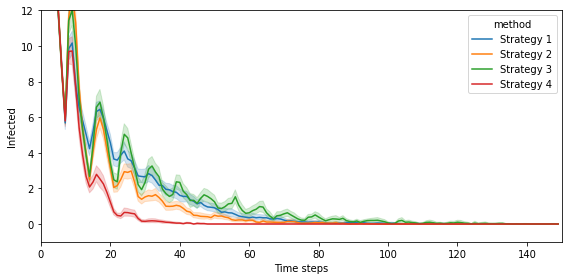

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 150)
plt.ylim(top = 12)
plt.tight_layout()

# Stochastic Bloack model (SBM)

In [ ]:
community_sizes = [10 for i in range(200)]
community_probs = [[0.06 if i==k else 0.0028 for i in range(200)] for k in range(200)]
G_temp = nx.stochastic_block_model(community_sizes, community_probs, seed = 42)
[G_temp.add_edge(i, random.randint(0,1999)) for i in list(nx.isolates(G_temp))]
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
print(list(nx.isolates(G)))

# of nodes:  2000
Average degree:  6.088
[]


In [ ]:
def network_gen():
  community_sizes = [10 for i in range(200)]
  community_probs = [[0.06 if i==k else 0.0028 for i in range(200)] for k in range(200)]
  G_temp = nx.stochastic_block_model(community_sizes, community_probs, seed = 42)
  [G_temp.add_edge(i, random.randint(0,1999)) for i in list(nx.isolates(G_temp))]
  G = nx.convert_node_labels_to_integers(G_temp)
  return G

##Testing Strategy _0

In [ ]:
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = network_gen())
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


11.249778985977173
      Susceptible  Exposed  Infected  Removed
Step                                         
0            1980        0        20        0
1            1960       20        18        2
2            1947       33        18        2
3            1938       42        17        3
4            1931       49        16        4
5            1929       51        16        4
6            1927       53        15        5
7            1921       59        11        9
8            1905       55        26       14
9            1879       68        35       18
10           1858       80        42       20
11           1834       97        46       23
12           1821      108        41       30
13           1796      131        41       32
14           1787      134        41       38
15           1768      137        51       44
16           1729      150        71       50
17           1705      153        82       60
18           1661      173        96       70
19           16

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  465
number_of_uninfected: 114


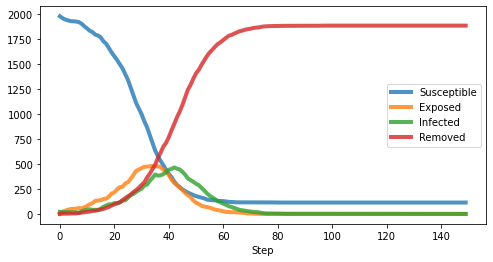

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
532                          10           12  0.319946
1675                          9           11  0.249818
232                           9           11  0.281475
697                           8            9  0.281127
1351                          8            9  0.234744
1043                          8           10  0.105087
1093                          8           10  0.167788
80                            8            8  0.313940
483                           8           10  0.189726
1753                          7            9  0.080655
394                           7           10  0.492639
1906                          7            7  0.562200
1313                          7            8  0.126385
934                           7            9  0.199704
1925                          7           12  0.205161
49                            7           11  0.265801
1020                          7            9  0.266731
1104                          7            9  0.180063
1137                          6           11  0.388432
298                           6           10  0.146788

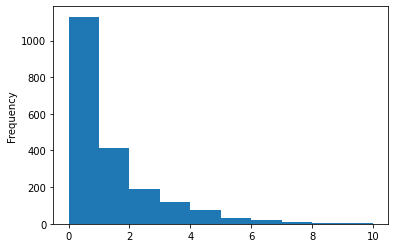

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

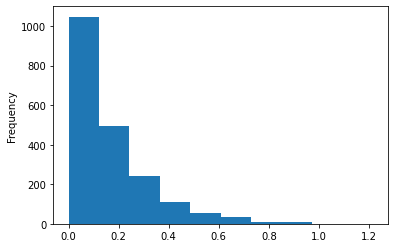

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      51.379108              114        41400                 20   
1      50.894443              361        41400                 20   
2      55.240756              242        41400                 20   
3      51.769799              406        41400                 21   
4      51.775060              688        41400                 31   
..           ...              ...          ...                ...   
95     49.767927              439        41400                 20   
96     49.202784              357        41400                 20   
97     53.531546              506        41400                 20   
98     49.376011              192        41400                 20   
99     49.344046              237        41400                 20   

    max_2_trans  num_of_S  
0             7      1863  
1            11      1553  
2             9      1706  
3            10      1504  
4            10      1137  
..          ...       ...  
95            9      1440  
96           10      1544  
97           15      1372  
98            8      1762  
99           10      1712  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  52.141519691944126 0.21783612238075292
Average_found_positives:  411.36 12.586320295696378
Average_total_tests:  41400.0 0.0
Average_max_outbreak_size:  20.73 0.20930621325964238
Average_max_2_trans: 9.92 0.16185790001720585
Average_number_of_uninfected: 1495.05 15.463083277420594


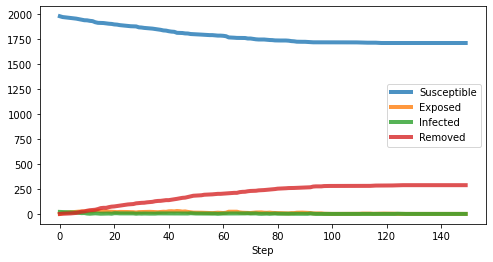

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


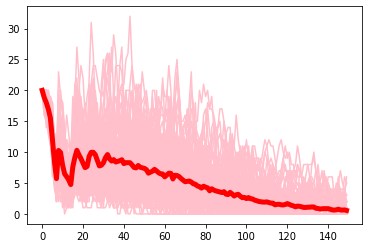

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

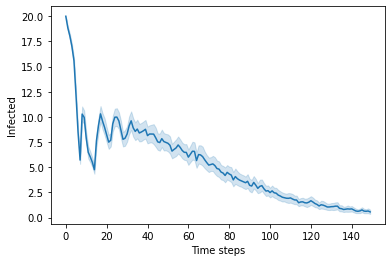

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
522                          10           12  0.340091
1499                          9           12  0.124111
708                           8            9  0.321453
1408                          7            9  0.242037
1893                          7            7  0.267157
1791                          7           11  0.558619
1490                          6           12  0.353202
429                           6            9  0.684610
979                           6           11  0.270158
1757                          6            8  0.116800
1712                          5           11  0.505792
1286                          5            6  0.524461
1602                          5            7  0.630081
517                           5            9  0.075358
912                           5            8  0.665056
1355                          5           10  0.373892
1147                          5            8  0.376876
1759                          4            9  0.087283
487                           4            9  0.092105
937                           4            7  0.037740

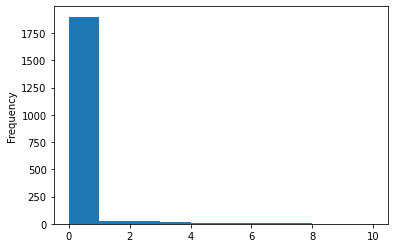

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

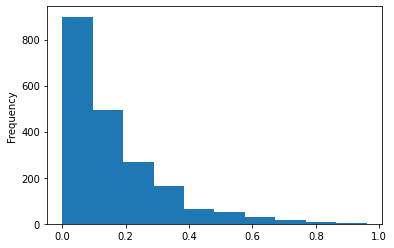

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      49.973048              456         5768                 20   
1      50.345861              353         5230                 20   
2      54.728065              599         6093                 20   
3      50.529050              480         5739                 20   
4      50.269378              374         5469                 20   
..           ...              ...          ...                ...   
95     48.551442              435         5582                 20   
96     52.848636              466         5551                 20   
97     48.735207              380         5550                 20   
98     49.261423              451         5587                 20   
99     49.236038              500         5871                 22   

    max_2_trans  num_of_S  
0            10      1506  
1            12      1607  
2            10      1347  
3            12      1486  
4             8      1596  
..          ...       ...  
95            9      1539  
96            9      1495  
97            9      1577  
98           10      1487  
99           13      1464  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  50.42642044782639 0.17302791390392927
Average_found_positives:  444.11 13.008287141027997
Average_total_tests:  5598.48 47.33973597328361
Average_max_outbreak_size:  20.13 0.059721576223896386
Average_max_2_trans: 9.54 0.137378045089917
Average_number_of_uninfected: 1518.51 13.703265812914594


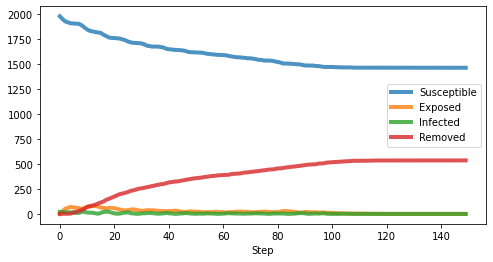

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


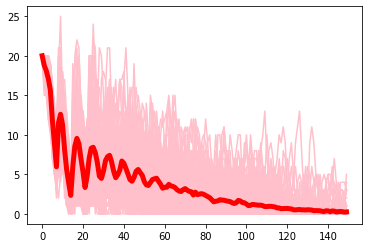

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


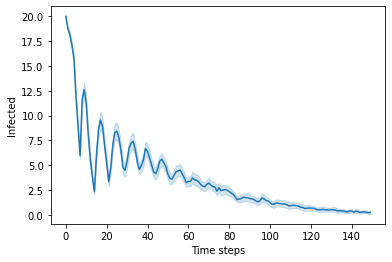

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1752                         13           13  0.697551
1214                         12           13  0.383657
1791                         10           11  0.499801
832                           9            9  0.407287
1211                          7           12  0.215290
1759                          7            9  0.474218
1730                          7            8  0.480039
1030                          7            9  0.269195
1541                          7            8  0.400494
986                           7            8  0.532321
1720                          7            9  0.430164
105                           6            8  0.530140
51                            6            9  0.359100
1970                          6            9  0.290765
1388                          6           11  0.201063
375                           5            7  0.364826
1903                          5            5  0.915726
1611                          5            9  0.135878
532                           5           12  0.220904
288                           5           10  0.285212

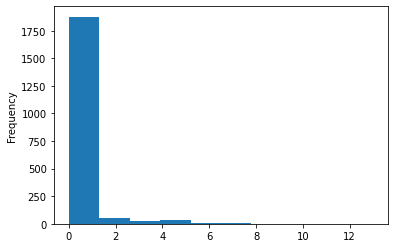

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

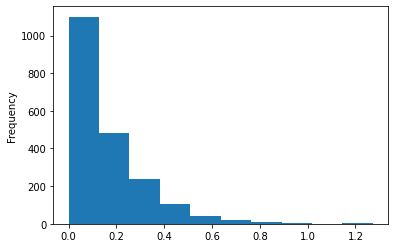

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0     101.091244              470         5790                 20   
1      91.258775              485         5795                 20   
2      53.427902              772         6755                 21   
3      55.685035              771         6785                 23   
4      55.221049              538         6052                 20   
..           ...              ...          ...                ...   
95     54.802632              630         6291                 20   
96     56.523487              634         6454                 20   
97     54.554014              735         6488                 23   
98     54.491323              571         6147                 25   
99     55.427966              559         6051                 20   

    max_2_trans  num_of_S  
0             9      1480  
1            10      1455  
2            11      1173  
3            11      1171  
4            11      1415  
..          ...       ...  
95           10      1288  
96           10      1326  
97            9      1192  
98            9      1373  
99           11      1381  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  55.45981400489807 0.5984647722969431
Average_found_positives:  624.84 15.160053303389674
Average_total_tests:  6265.69 51.5446333900352
Average_max_outbreak_size:  21.53 0.34273263131142995
Average_max_2_trans: 9.79 0.1208513570674757
Average_number_of_uninfected: 1320.29 15.975696788521867


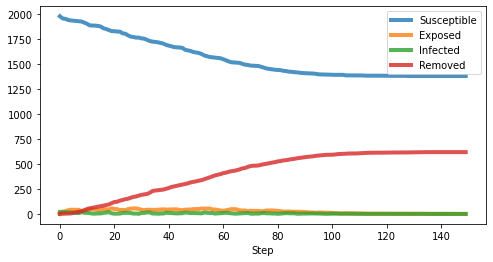

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


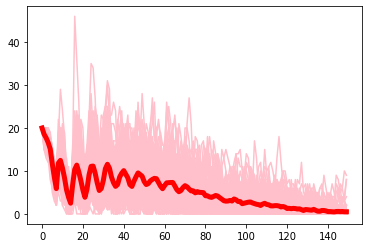

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


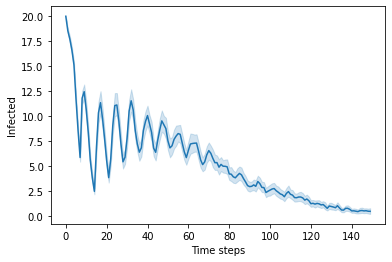

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1054                         11           12  0.489063
1178                          9            9  0.877470
3                             8           11  0.193190
1955                          8           10  0.195184
148                           7            9  0.455566
92                            7            8  0.736629
1309                          7           10  0.244438
60                            7           11  0.302577
1275                          6            8  0.199674
1251                          6            8  0.400831
169                           6           10  0.337945
694                           6            7  0.372777
880                           6            8  0.297650
1708                          6            9  0.862415
137                           5            7  0.115395
1926                          5            9  0.076980
227                           5            9  0.548050
1786                          5            7  0.572482
994                           5            7  0.307004
1551                          5            9  0.148999

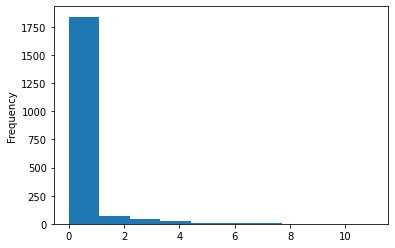

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

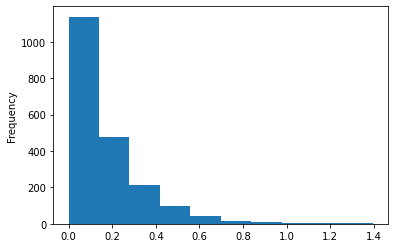

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      56.583498               88         4281                 20   
1      64.069273              604         6431                 20   
2      56.894083              407         5534                 20   
3      59.685475              528         6213                 20   
4      57.445803              429         5632                 20   
..           ...              ...          ...                ...   
95     55.996969              400         5773                 20   
96     51.545541               79         4282                 20   
97     58.183864              487         5839                 20   
98     54.596342              296         5027                 20   
99     58.398526              430         5571                 20   

    max_2_trans  num_of_S  
0             6      1895  
1            10      1353  
2             9      1561  
3            10      1432  
4            11      1527  
..          ...       ...  
95            9      1567  
96            6      1902  
97            9      1480  
98            9      1675  
99           10      1526  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

In [ ]:
group_df

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      53.150672              167         4491                 20   
1      58.816261              550         5687                 20   
2      59.358483              349         5001                 20   
3      55.861033              317         5115                 20   
4      57.817986              355         5089                 20   
..           ...              ...          ...                ...   
95     52.901383              129         4361                 20   
96     53.969569              304         4960                 20   
97     53.358153              257         4665                 20   
98     57.210725              425         5391                 20   
99     53.005321              213         4640                 20   

    max_2_trans  num_of_S  
0            11      1806  
1             9      1392  
2            10      1618  
3            13      1652  
4             9      1605  
..          ...       ...  
95            8      1856  
96           10      1669  
97            9      1712  
98           10      1540  
99            8      1768  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  56.1910196352005 0.25012004758340994
Average_found_positives:  283.94 12.624113690261446
Average_total_tests:  4879.66 43.90243825630285
Average_max_outbreak_size:  20.11 0.054855181241983964
Average_max_2_trans: 9.31 0.14681466362235568
Average_number_of_uninfected: 1686.2 13.694163027001725


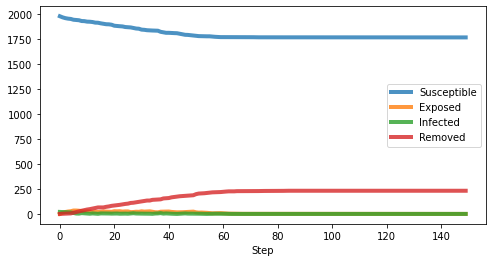

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


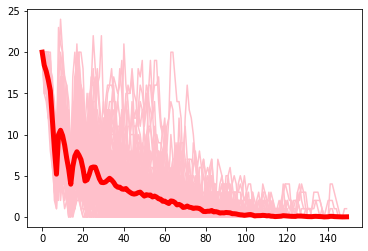

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


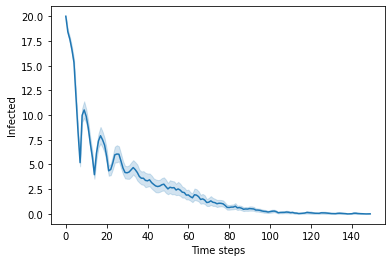

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
122                           8           11  0.151460
1159                          8           13  0.293145
1424                          7            8  0.566546
852                           6            8  0.275450
1244                          6            9  0.113447
1832                          6            8  0.611709
90                            6            9  0.472953
1858                          6           10  0.150906
1393                          5            8  0.158427
1735                          5            5  0.194084
601                           5            6  0.410467
465                           5            7  0.180786
263                           5            6  0.285875
761                           5            6  0.620433
91                            5            8  0.076930
438                           4            8  0.212402
1990                          4            7  0.379100
543                           4            7  0.268757
1181                          4            6  0.298313
672                           4           10  0.089511

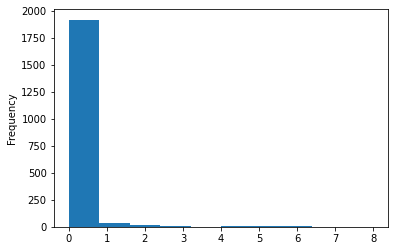

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

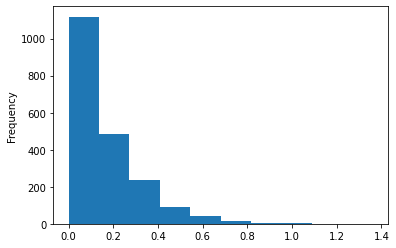

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(1442, 64), (1918, 64), (1781, 67), (658, 78), (653, 82)]

In [ ]:
group_df

Group  Degree  Intra_C  \
6    [1130, 1513, 1227, 325, 684, 1368, 1509, 1556,...      63        9   
101  [705, 699, 1452, 176, 834, 941, 1376, 407, 661...      60        6   
87   [1984, 1652, 1653, 1816, 327, 507, 1633, 1810,...      74        7   
151  [1158, 1097, 1104, 1202, 1350, 1312, 1758, 107...      76        6   
147  [1059, 1094, 1096, 1056, 1566, 1434, 1856, 952...      62        7   
..                                                 ...     ...      ...   
180  [1475, 18, 1478, 1592, 360, 463, 1526, 1670, 7...      57        8   
160  [1288, 106, 382, 1679, 347, 1141, 225, 373, 39...      70        9   
110  [481, 284, 417, 902, 1209, 295, 907, 466, 881,...      57        7   
184  [340, 419, 1654, 1706, 135, 398, 391, 882, 170...      49        6   
125  [575, 700, 772, 503, 1523, 639, 957, 796, 1067...      56        8   

        order  record  flag  
6    0.000002      22     1  
101  0.000002      19     1  
87   0.000002      21     1  
151  0.000002      23     1  
147  0.000002      19     1  
..        ...     ...   ...  
180  0.000002      19     0  
160  0.000002      21     0  
110  0.000002      21     0  
184  0.000002      19     0  
125  0.000002      19     0  

[200 rows x 6 columns]

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
122                           8           11  0.151460
1159                          8           13  0.293145
1424                          7            8  0.566546
852                           6            8  0.275450
1244                          6            9  0.113447
1832                          6            8  0.611709
90                            6            9  0.472953
1858                          6           10  0.150906
1393                          5            8  0.158427
1735                          5            5  0.194084
601                           5            6  0.410467
465                           5            7  0.180786
263                           5            6  0.285875
761                           5            6  0.620433
91                            5            8  0.076930
438                           4            8  0.212402
1990                          4            7  0.379100
543                           4            7  0.268757
1181                          4            6  0.298313
672                           4           10  0.089511

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

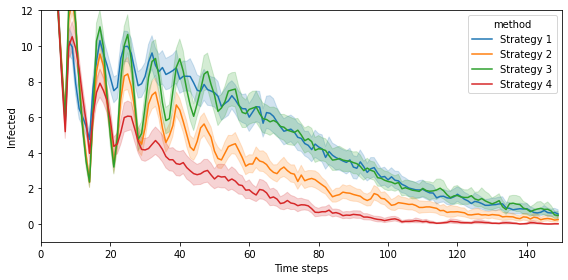

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 150)
plt.ylim(top = 12)
plt.tight_layout()

# Waxman's Model

In [ ]:
G_temp = nx.waxman_graph(2000, 0.18, 0.04)#, metric=dist)
[G_temp.add_edge(i, random.randint(0,1999)) for i in list(nx.isolates(G_temp))]
G = nx.convert_node_labels_to_integers(G_temp)

print("# of nodes: ", G.number_of_nodes())
print("Average degree: ", 2*G.number_of_edges()/G.number_of_nodes())
print(list(nx.isolates(G)))

# of nodes:  2000
Average degree:  5.847
[]


In [ ]:
def network_gen():
  G_temp = nx.waxman_graph(2000, 0.18, 0.04)#, metric=dist)
  [G_temp.add_edge(i, random.randint(0,1999)) for i in list(nx.isolates(G_temp))]
  G = nx.convert_node_labels_to_integers(G_temp)
  return G

##Testing Strategy _0

In [ ]:
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, avg_node_degree=6, data_G = network_gen())
for i in range(steps):
    model.step()
print (time.time()-st)
#agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:30])


14.619469404220581
      Susceptible  Exposed  Infected  Removed
Step                                         
0            1980        0        20        0
1            1972        8        18        2
2            1967       13        18        2
3            1961       19        18        2
4            1955       25        17        3
5            1948       32        16        4
6            1944       36        15        5
7            1940       40        12        8
8            1932       40        16       12
9            1920       47        19       14
10           1909       52        19       20
11           1890       65        24       21
12           1874       74        28       24
13           1864       80        28       28
14           1853       87        28       32
15           1843       89        29       39
16           1830       90        40       40
17           1816       93        50       41
18           1784      106        62       48
19           17

In [ ]:
print("max_outbreak_size: ", get_column_data(model).Infected.max())
print("number_of_uninfected:",get_column_data(model).Susceptible.min())

max_outbreak_size:  356
number_of_uninfected: 158


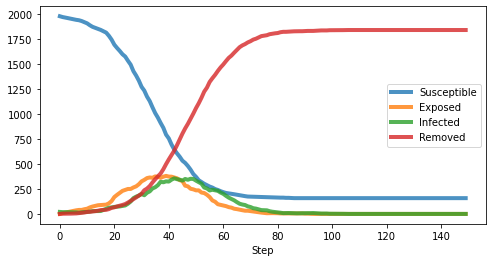

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1538                         10           13  0.321225
794                          10           11  0.274721
1324                         10           14  0.249442
421                           9           13  0.489844
750                           9           10  0.214577
1391                          9           11  0.145020
535                           8           10  0.334308
97                            8            9  0.326531
804                           7            8  0.372820
346                           7            7  0.149481
1365                          7            8  0.601179
1518                          7           10  0.229715
1733                          7           10  0.214718
1939                          7           10  0.204135
1452                          7           10  0.381055
144                           7            8  0.479017
412                           7           13  0.109013
690                           7           11  0.337785
1086                          7           13  0.150057
836                           6            7  0.460844

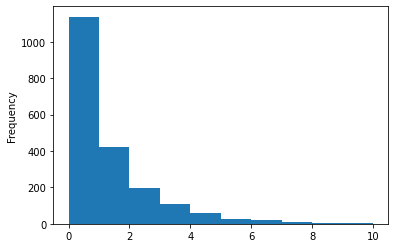

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

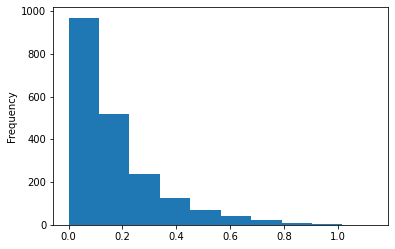

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _1

In [ ]:
#model set_up for strategy 1
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    ind = random.sample(range(1,pop+1), pop)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0

    if np.mod(pop, capacity) != 0:
        null_tail = [0] * (capacity - np.mod(pop, capacity))
        finish_flag = int(np.ceil(pop/capacity))
        ind.extend(null_tail)
        t_order = np.array(ind).reshape(finish_flag, capacity)
    else:
      finish_flag = int(pop/capacity)
      t_order = np.array(ind).reshape(finish_flag, capacity)
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            if test_key < finish_flag:
                temp = model.datacollector.get_agent_vars_dataframe()
                temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
                infection_matrix = csr_matrix(temp.values)
                for v in t_order[test_key]:
                    if v == 0:
                        test_key = 0
                        break
                    n_tests += 1
                    if infection_matrix[v-1, i] == 2:
                        model.schedule.agents[v-1].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v,i))) 
                    if infection_matrix[v-1, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v-1].exposed_time) > 4:
                            model.schedule.agents[v-1].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v,i)))
                test_key += 1
                if test_key == finish_flag:
                    test_key = 0
                
            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()

    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      53.843535              452        41400                 27   
1      52.619326              296        41400                 20   
2      52.115298              606        41400                 20   
3      54.569105              373        41400                 20   
4      53.126049              374        41400                 20   
..           ...              ...          ...                ...   
95     55.226773              305        41400                 20   
96     52.957617              508        41400                 20   
97     53.700072              355        41400                 20   
98     54.023588              211        41400                 20   
99     53.623091              476        41400                 20   

    max_2_trans  num_of_S  
0            12      1446  
1            11      1638  
2            12      1252  
3            13      1553  
4             9      1553  
..          ...       ...  
95            9      1617  
96            9      1378  
97           12      1588  
98           12      1757  
99           11      1423  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  53.14017450809479 0.10130042214584664
Average_found_positives:  368.37 13.103678680030844
Average_total_tests:  41400.0 0.0
Average_max_outbreak_size:  20.46 0.14243197915801314
Average_max_2_trans: 10.39 0.1830686795007311
Average_number_of_uninfected: 1548.28 16.21005474227261


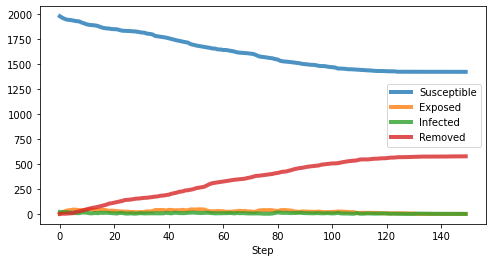

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


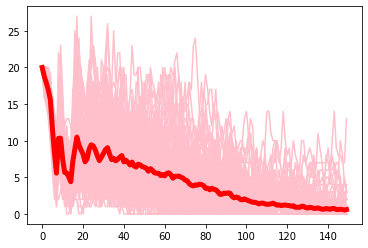

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)

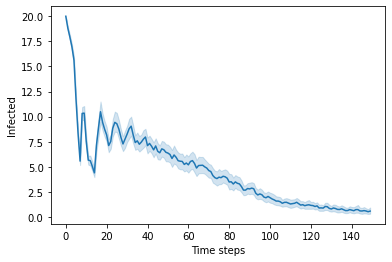

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_1 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1748                         11           13  0.917015
706                          10           11  0.352370
235                          10           11  0.550161
1853                         10           13  0.644856
1478                          8           10  0.223280
1305                          8           11  0.485355
975                           8           11  0.434029
97                            8           14  0.419832
1444                          8            9  0.620057
395                           8            9  0.776642
792                           8            8  0.286151
1068                          7           11  0.582187
1560                          7           11  0.064471
98                            7            9  0.341111
1961                          7           14  0.626147
1153                          7           10  0.192253
400                           6            7  0.310934
577                           6            8  0.109220
562                           6            8  0.567780
187                           6            7  0.271884

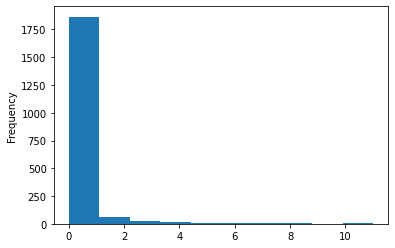

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

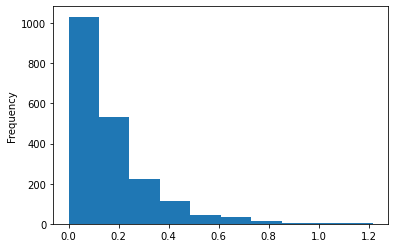

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _2

In [ ]:
#model set_up for strategy 2
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = random_groups(model.G, group_size)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0

      
    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

            
    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      53.493520              441         5536                 21   
1      55.896977              547         5935                 20   
2      54.926983              412         5576                 20   
3      58.150187              360         5367                 20   
4      58.974362              379         5414                 20   
..           ...              ...          ...                ...   
95     55.945108              471         5773                 20   
96     57.786223              315         5026                 20   
97     56.289380              481         5759                 20   
98     56.658434              578         6201                 20   
99     58.988249              472         5672                 20   

    max_2_trans  num_of_S  
0             9      1520  
1            10      1403  
2            12      1546  
3             8      1610  
4             9      1589  
..          ...       ...  
95           10      1486  
96            9      1659  
97           13      1483  
98           11      1374  
99           11      1486  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  56.53094835758209 0.16453472899291507
Average_found_positives:  422.75 13.34936441569524
Average_total_tests:  5542.85 47.187180194916024
Average_max_outbreak_size:  20.22 0.07046741492105814
Average_max_2_trans: 9.84 0.14475336042225534
Average_number_of_uninfected: 1541.55 14.080456941334242


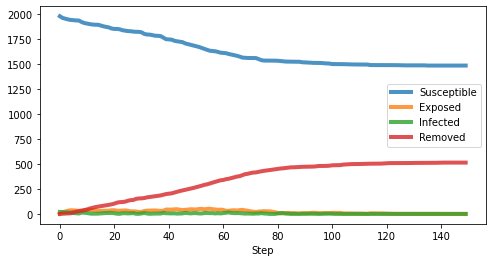

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


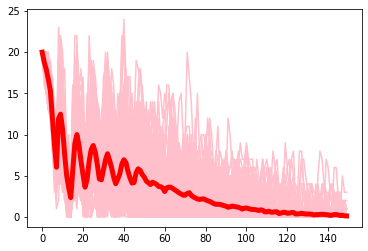

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


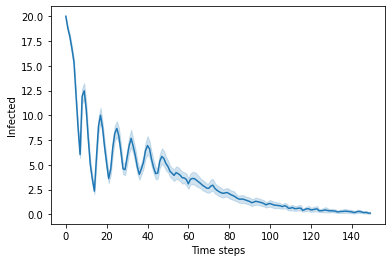

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_2 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1979                         11           11  0.750282
450                          11           13  0.487211
1035                          9           12  0.342684
44                            8           13  0.307425
812                           8            9  0.902854
1735                          8           11  0.394231
504                           7            9  0.342550
1233                          7            8  0.502601
1052                          7           12  0.179822
1995                          7            9  0.287094
1399                          6            8  0.442201
714                           6            9  0.888962
85                            6            7  0.706460
1925                          6            8  0.394591
563                           6           15  0.129014
888                           6           10  0.054838
1178                          6            7  0.608019
1171                          6            8  0.431656
1562                          6           10  0.410102
391                           6            9  0.420208

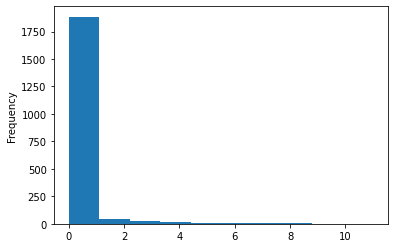

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

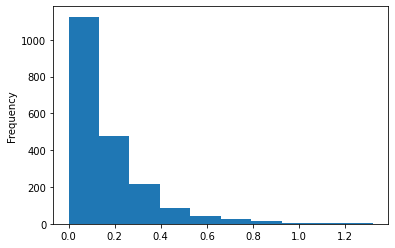

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _3

In [ ]:
#model set_up for strategy 3
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    random.shuffle(rand_groups)
    n_tests = 0
    found_positive = 0
    positive_ind = []
    test_key = 0
    ind_c_flag = 0
        

    for i in range(steps):
        model.step()
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            for g in range(int(np.floor(capacity/(group_size+1)))):
                n_tests += 1
                remove_rec = 0
                for v in rand_groups[test_key]:
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive += 1
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive += 1
                            positive_ind.append(tuple((v+1,i)))
                if ind_c_flag == 1:
                    n_tests += (len(rand_groups[test_key]) - remove_rec)
                    ind_c_flag = 0
                    remove_rec = 0
                
                test_key += 1
                if test_key == len(rand_groups):
                    test_key = 0

    running_time[trail] = time.time()-st
    found_positives[trail] = found_positive
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      57.603874              680         6352                 20   
1      58.632977              451         5562                 20   
2      58.423300              583         6130                 20   
3      58.123161              138         4419                 20   
4      58.260416              544         6012                 20   
..           ...              ...          ...                ...   
95     56.622386              843         6908                 24   
96     56.922366              523         5927                 20   
97     59.038259              499         5770                 20   
98     57.486736              427         5458                 20   
99     57.379901              517         5873                 20   

    max_2_trans  num_of_S  
0            10      1278  
1             8      1493  
2             9      1370  
3             8      1847  
4            12      1400  
..          ...       ...  
95            9      1089  
96            9      1407  
97            8      1432  
98           10      1538  
99           10      1426  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  57.82068257808685 0.13201855981328225
Average_found_positives:  542.73 14.216364556809916
Average_total_tests:  5932.89 48.09594345438789
Average_max_outbreak_size:  20.82 0.16476490751211176
Average_max_2_trans: 10.29 0.1519536080186943
Average_number_of_uninfected: 1407.2 15.040000537287762


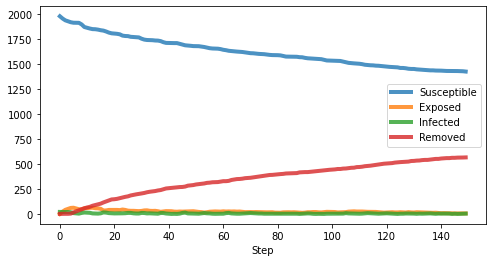

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


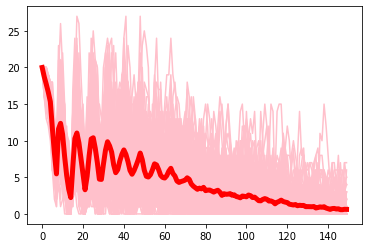

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


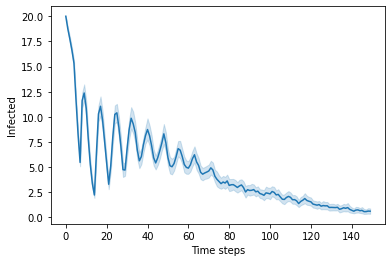

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_3 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
728                          10           10  0.340808
58                            9           15  0.359738
717                           8            9  0.246619
1481                          7            8  0.642715
77                            7           18  0.375863
1320                          7            9  0.253153
1167                          7           12  0.326086
1069                          6            7  0.453169
965                           6           11  0.283914
936                           6            7  0.330380
1139                          6            7  0.358130
1535                          6            7  0.609354
1940                          6           11  1.056405
1083                          6            8  0.120521
1147                          5            7  0.659490
254                           5            6  0.308308
1161                          5            6  0.112099
1027                          5            7  0.190824
1448                          5            6  0.430546
1760                          5            6  0.587119

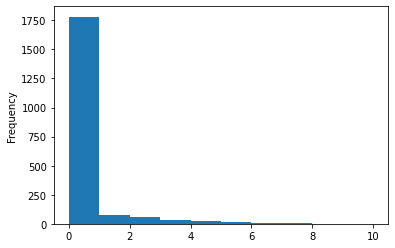

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

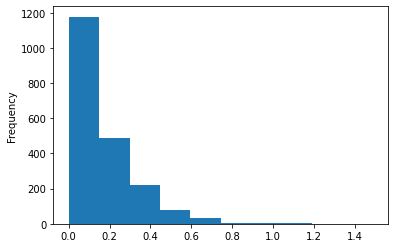

In [ ]:
icc_cc.p.plot.hist()

##Testing Strategy _4

In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)
            else:
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      69.385481              686         7047                 25   
1      63.342652              317         5298                 20   
2      64.860898              497         6193                 20   
3      68.889463              667         6916                 23   
4      65.992868              645         6702                 20   
..           ...              ...          ...                ...   
95     63.050363              446         5959                 20   
96     63.416301              467         6095                 20   
97     62.290233              316         5087                 20   
98     62.815814              429         5815                 20   
99     63.954406              462         6062                 20   

    max_2_trans  num_of_S  
0             9      1260  
1             9      1647  
2             8      1470  
3            11      1271  
4             8      1301  
..          ...       ...  
95            9      1513  
96           10      1498  
97            8      1643  
98           10      1533  
99           12      1494  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  63.656115081310276 0.2757516037414055
Average_found_positives:  445.76 15.745636689174393
Average_total_tests:  5849.0 73.65584865035525
Average_max_outbreak_size:  20.93 0.24256832839304057
Average_max_2_trans: 9.83 0.13710940849916137
Average_number_of_uninfected: 1512.29 17.154210220317005


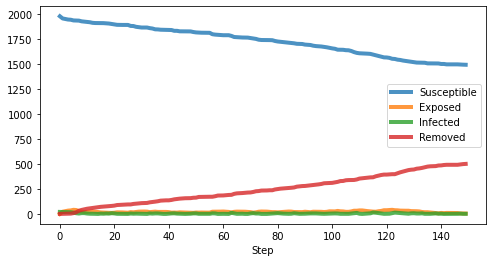

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


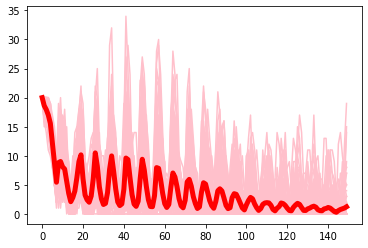

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


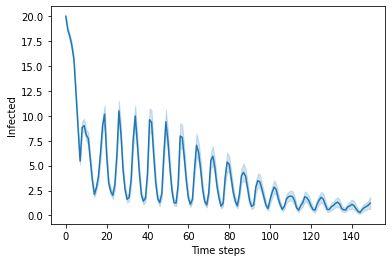

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_4 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1113                         12           15  0.575617
1991                          9           11  0.579935
194                           7           10  0.298113
1025                          7           11  0.324516
1213                          7            9  0.473609
57                            7           13  0.922191
762                           7           11  0.238099
1907                          7            9  0.799405
1859                          7           11  1.101188
782                           6            8  0.391141
561                           6           10  0.108455
659                           6           11  0.310105
1963                          6            9  0.227112
1889                          6            8  0.382247
286                           6            8  0.905851
287                           6            6  0.550795
1386                          5            9  0.858173
439                           5           10  0.496191
1094                          5            7  0.606512
1427                          5           11  0.601269

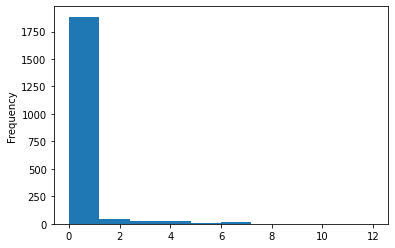

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

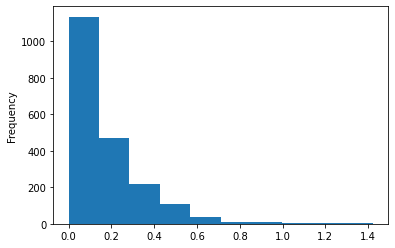

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(1266, 147), (1837, 147), (1996, 147), (1131, 148), (1432, 148)]

In [ ]:
group_df

Group  Degree  Intra_C  \
34   [1269, 1408, 1506, 178, 433, 1380, 1730, 1675,...      73       10   
90   [1684, 1349, 1452, 1373, 1629, 1378, 1647, 159...      70        8   
25   [1159, 1355, 1309, 1640, 1328, 1772, 1815, 121...      70       10   
47   [285, 589, 780, 1912, 869, 1160, 1327, 1848, 2...      96       10   
121  [214, 288, 313, 549, 585, 773, 1112, 182, 676,...      80        7   
..                                                 ...     ...      ...   
94   [1807, 427, 1965, 126, 439, 1835, 27, 78, 1734...      60        8   
75   [348, 688, 1209, 801, 1089, 1177, 1528, 837, 1...      53        7   
116  [1525, 107, 1796, 284, 795, 314, 1302, 651, 82...      48        7   
91   [1369, 1420, 1443, 1736, 1430, 1643, 1701, 145...      46        8   
71   [303, 401, 613, 721, 701, 1391, 871, 326, 456,...      45        8   

        order  record  flag  
34   0.003273      21     1  
90   0.002560      21     1  
25   0.001863      21     1  
47   0.001779      21     1  
121  0.001025      21     1  
..        ...     ...   ...  
94   0.000005      20     0  
75   0.000004      20     0  
116  0.000004      20     0  
91   0.000004      20     0  
71   0.000004      20     0  

[200 rows x 6 columns]

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
1113                         12           15  0.575617
1991                          9           11  0.579935
194                           7           10  0.298113
1025                          7           11  0.324516
1213                          7            9  0.473609
57                            7           13  0.922191
762                           7           11  0.238099
1907                          7            9  0.799405
1859                          7           11  1.101188
782                           6            8  0.391141
561                           6           10  0.108455
659                           6           11  0.310105
1963                          6            9  0.227112
1889                          6            8  0.382247
286                           6            8  0.905851
287                           6            6  0.550795
1386                          5            9  0.858173
439                           5           10  0.496191
1094                          5            7  0.606512
1427                          5           11  0.601269

##Testing Strategy_4_high_2


In [ ]:
def raise_order(infected, strategy_df, group_number):
  #neighbor_list = [n for n in model.G.neighbors(infected)]
  for n in model.G.neighbors(infected):
    for i in range(strategy_df.shape[0]):
      if n in strategy_df['Group'][i]:
        if strategy_df.iloc[i].name == group_number:
          continue
        else:
          strategy_df['order'][i] = strategy_df['order'][i] * 1.2
          #strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
def adjust_order(strategy_df):
  for i in range(strategy_df.shape[0]):
    if strategy_df['tracing'][i] > 4:
      strategy_df['order'][i] = strategy_df['order'][i] + 0.8
      strategy_df['tracing'][i] = 0
    if strategy_df['tracing'][i] > 0:
      strategy_df['tracing'][i] = strategy_df['tracing'][i] + 1

In [ ]:
#model set_up for strategy 4
pop=2000
steps=150
st=time.time()
model = NetworkInfectionModel(pop, data_G = network_gen())

#for testing
group_size = 10
capacity = 300
start_delay = 3

#simu stats
n_trails = 100
running_time, found_positives, total_tests, max_outbreak_size, max_2_trans, num_of_S= [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails, [0]*n_trails
infect_rec = []
#===============================================================
for trail in range(n_trails):
    st=time.time()
    model = NetworkInfectionModel(pop, data_G = network_gen())

    #testing order setup
    rand_groups = max_intra_commu_greedy(model.G, group_size, weight=None)
    n_tests = 0
    found_positive = [0]* steps
    positive_ind = []
    test_key = 0
    two_step_cap = int(np.floor(capacity/(group_size+1)))

    #df setup
    sub_inside = [model.G.subgraph(i).number_of_edges() for i in rand_groups]
    degree_list = [sum(model.G.degree(i) for i in k) for k in rand_groups]
    group_df = pd.DataFrame({'Group':rand_groups, 'Degree':degree_list, 'Intra_C':sub_inside})
    scaler = MinMaxScaler()
    group_df['order'] = scaler.fit_transform(group_df[['Intra_C']])*0.75 + scaler.fit_transform(group_df[['Degree']])*0.25 + 0.1
    group_df['record'] = 0
    #group_df['tracing'] = 0
    group_df['flag'] = 0
    group_df.sort_values(by = ['order','record'], ascending=[False,True], inplace=True)
        

    for i in range(steps):
        model.step()
        #adjust_order(group_df)
        if i > start_delay:
            temp = model.datacollector.get_agent_vars_dataframe()
            temp = pd.pivot_table(temp.reset_index(), index='AgentID', columns='Step', values= 'State')
            infection_matrix = csr_matrix(temp.values)

            #sort and get current top
            if sum(found_positive[-3:]) > (0.3*group_size):
              group_df.sort_values(by = ['flag','record','order'], ascending=[True, True, False], inplace=True)
            else:
              group_df.sort_values(by = ['flag','order','record'], ascending=[True, False, True], inplace=True)              
            group_list = group_df['Group'].head(two_step_cap).tolist()
            group_df['record'].iloc[:two_step_cap] = group_df['record'].iloc[:two_step_cap] + 1
            #reset repeat flag
            group_df['flag'] = [0 if i == 1 else i for i in group_df['flag']]
            group_df['flag'].iloc[:two_step_cap] = group_df['flag'].iloc[:two_step_cap] + 1
            group_df['order'].iloc[:two_step_cap] = group_df['order'].iloc[:two_step_cap]*0.5

            for g in range(two_step_cap):
                n_tests += 1
                
                for v in group_list[g]:
                    remove_rec = 0
                    if infection_matrix[v, i] == 2:
                        model.schedule.agents[v].state = State.REMOVED
                        found_positive[i] += 1
                        raise_order(v, group_df, group_df.iloc[g].name)
                        positive_ind.append(tuple((v+1,i)))
                        ind_c_flag = 1
                    if infection_matrix[v, i] == 3:
                        #no test for removed agents
                        remove_rec += 1
                    if remove_rec == group_size:
                       group_df.iloc[g].flag = 100    
                    if infection_matrix[v, i] == 1:
                        if (model.schedule.time - model.schedule.agents[v].exposed_time) > 4:
                            model.schedule.agents[v].state = State.REMOVED
                            found_positive[i] += 1
                            raise_order(v, group_df, group_df.iloc[g].name)
                            positive_ind.append(tuple((v+1,i)))                   
                if ind_c_flag == 1:
                    n_tests += (len(group_list[g]) - remove_rec)
                    ind_c_flag = 0



            
    #print("running_time:", time.time()-st)
    #print("found_positive: ", found_positive)
    #print("total_tests: ",  n_tests)
    #print("max_outbreak_size: ", get_column_data(model).Infected.max())

    running_time[trail] = time.time()-st
    found_positives[trail] = sum(found_positive)
    total_tests[trail] = n_tests
    max_outbreak_size[trail] = get_column_data(model).Infected.max()
    max_2_trans[trail] = get_secondary_transmission(model).Secondary_transmission.max()
    num_of_S[trail] = get_column_data(model).Susceptible.min()
    infect_rec.append(get_column_data(model).Infected.tolist())

    trail += 1
            
#print("running time:", time.time()-st)
#print("found_positive: ", found_positive)
#print("total_tests: ",  n_tests)
#agent_state = model.datacollector.get_agent_vars_dataframe()
#print (get_column_data(model)[:30])
simu_rec = pd.DataFrame({'running_time':running_time, 'found_positives':found_positives, 'total_tests':total_tests, 'max_outbreak_size':max_outbreak_size, 'max_2_trans':max_2_trans, "num_of_S":num_of_S})
simu_rec

running_time  found_positives  total_tests  max_outbreak_size  \
0      59.385576              118         4261                 20   
1      60.472399              202         4497                 20   
2      58.862711              218         4511                 20   
3      60.440133              277         4857                 21   
4      61.725847              407         5114                 20   
..           ...              ...          ...                ...   
95     61.092934              241         4635                 20   
96     59.332451              214         4608                 20   
97     63.544971              328         4842                 20   
98     61.579821              207         4586                 20   
99     61.775542              281         4964                 20   

    max_2_trans  num_of_S  
0             9      1864  
1             8      1779  
2            11      1763  
3             9      1693  
4            10      1556  
..          ...       ...  
95           11      1733  
96           10      1766  
97           10      1636  
98           12      1766  
99           10      1682  

[100 rows x 6 columns]

In [ ]:
print("Average_running_time: ", simu_rec.running_time.mean(), sem(simu_rec.running_time))
print("Average_found_positives: ", simu_rec.found_positives.mean(),sem(simu_rec.found_positives))
print("Average_total_tests: ", simu_rec.total_tests.mean(), sem(simu_rec.total_tests))
print("Average_max_outbreak_size: ", simu_rec.max_outbreak_size.mean(), sem(simu_rec.max_outbreak_size))
print("Average_max_2_trans:", simu_rec.max_2_trans.mean(), sem(simu_rec.max_2_trans))
print("Average_number_of_uninfected:", simu_rec.num_of_S.mean(), sem(simu_rec.num_of_S))

Average_running_time:  60.558203489780425 0.18938009982607315
Average_found_positives:  215.86 8.715689092873628
Average_total_tests:  4594.09 26.80804603702463
Average_max_outbreak_size:  20.03 0.022270150335361366
Average_max_2_trans: 9.67 0.17526603155826237
Average_number_of_uninfected: 1760.06 9.409878969584158


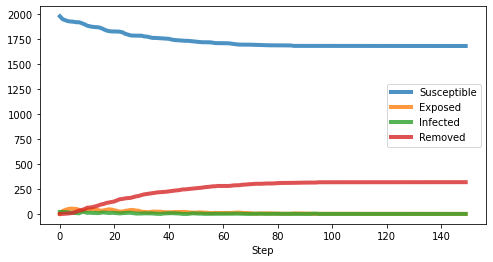

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SEIR.png',dpi=150)


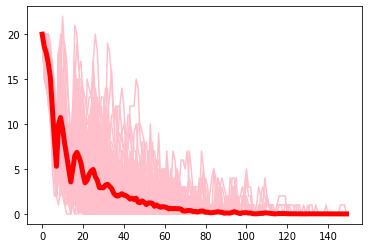

In [ ]:
temp = pd.DataFrame()
for i in range(len(infect_rec)):
  temp[i] = infect_rec[i]
  plt.plot(infect_rec[i], color='pink')
temp['avg'] = temp.mean(axis=1)
plt.plot(temp['avg'].tolist(), color='red', linewidth=5)


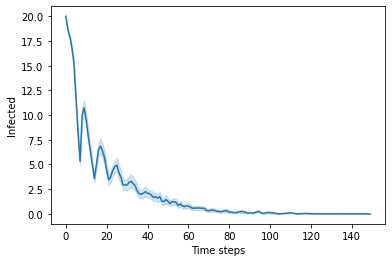

In [ ]:
df_infect = pd.DataFrame(np.array(infect_rec)).melt()
ax = sns.lineplot(x="variable", y="value", data=df_infect)
ax.set(xlabel='Time steps', ylabel='Infected')
df_infect_5 = df_infect

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
905                          10           12  0.350007
1672                          8            8  0.471908
1393                          8            8  0.314895
1001                          7            8  0.152552
1651                          6            7  0.552893
789                           6           10  0.101275
1094                          6           10  0.147615
1779                          6            9  0.474725
327                           6            9  0.446401
1633                          6           12  0.373003
849                           6            8  0.363166
336                           5            7  0.275534
37                            5            7  0.398928
647                           5           10  0.274238
1286                          5            9  0.162642
1314                          5            6  0.588454
1315                          5            8  0.474239
1794                          5           12  0.232841
1011                          5            6  0.157179
1441                          5           11  0.104574

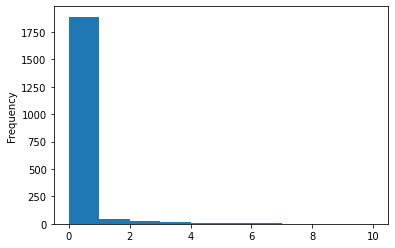

In [ ]:
icc_cc.Secondary_transmission.plot.hist()

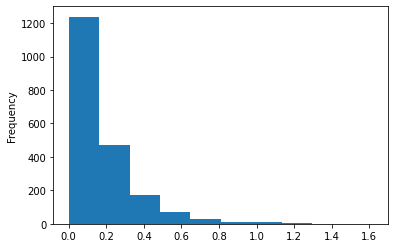

In [ ]:
icc_cc.p.plot.hist()

In [ ]:
positive_ind[-5:]

[(453, 88), (1829, 89), (1486, 94), (201, 94), (1861, 98)]

In [ ]:
group_df

Group  Degree  Intra_C  \
63   [802, 6, 243, 442, 472, 600, 784, 542, 1139, 918]      57        7   
65   [735, 486, 1386, 535, 1071, 501, 1317, 947, 16...      60        9   
77   [1502, 286, 393, 846, 1826, 1599, 1968, 1828, ...      68        8   
122  [454, 474, 519, 650, 966, 667, 1242, 196, 320,...      67        6   
70   [1345, 677, 1017, 915, 1098, 653, 1024, 951, 1...      47        6   
..                                                 ...     ...      ...   
7    [573, 764, 583, 721, 933, 1539, 811, 1472, 177...      55       10   
90   [1680, 105, 965, 1268, 1777, 1659, 1800, 1583,...      57        8   
162  [1159, 323, 718, 1927, 92, 146, 843, 891, 1143...      66       10   
96   [473, 750, 922, 1706, 770, 1140, 479, 1203, 12...      55        6   
87   [1763, 1258, 1484, 1802, 1013, 1700, 1099, 118...      64        7   

        order  record  flag  
63   0.000003      21     1  
65   0.000003      19     1  
77   0.000003      22     1  
122  0.000003      20     1  
70   0.000003      18     1  
..        ...     ...   ...  
7    0.000003      21     0  
90   0.000003      20     0  
162  0.000003      19     0  
96   0.000003      20     0  
87   0.000003      19     0  

[200 rows x 6 columns]

In [ ]:
ic = model.datacollector_infection_counts.get_agent_vars_dataframe()
icc_cc = pd.pivot_table(ic,index='AgentID',values = ['Secondary_transmission','p','node_degree'], aggfunc= {'Secondary_transmission':np.sum,'p':np.mean, 'node_degree':np.mean}, fill_value=0).sort_values(by='Secondary_transmission', ascending=False)
icc_cc.head(20)

Secondary_transmission  node_degree         p
AgentID                                               
905                          10           12  0.350007
1672                          8            8  0.471908
1393                          8            8  0.314895
1001                          7            8  0.152552
1651                          6            7  0.552893
789                           6           10  0.101275
1094                          6           10  0.147615
1779                          6            9  0.474725
327                           6            9  0.446401
1633                          6           12  0.373003
849                           6            8  0.363166
336                           5            7  0.275534
37                            5            7  0.398928
647                           5           10  0.274238
1286                          5            9  0.162642
1314                          5            6  0.588454
1315                          5            8  0.474239
1794                          5           12  0.232841
1011                          5            6  0.157179
1441                          5           11  0.104574

##Vis

In [ ]:
df_infect_1['method'] = 'Strategy 1'
df_infect_2['method'] = 'Strategy 2'
df_infect_3['method'] = 'Strategy 3'
df_infect_5['method'] = 'Strategy 4'

In [ ]:
temp = pd.concat([df_infect_1, df_infect_2, df_infect_3, df_infect_5])
temp = temp.reset_index()

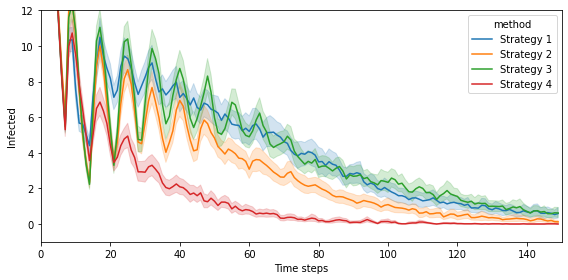

In [ ]:
f,ax=plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(x="variable", y="value", hue = "method", data=temp)
ax.set(xlabel='Time steps', ylabel='Infected')
plt.xlim(0, 150)
plt.ylim(top = 12)
plt.tight_layout()